# Previsão de tarifa de táxi de Nova Iorque

A base de dados usada pode ser encontrada na plataforma Kaggle por meio do seguinte link: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview. 

Descrição traduzida:

> Nesta competição [...] você tem a tarefa de prever o valor da tarifa (inclusive pedágios) para uma corrida de táxi em Nova Iorque, dado os locais de partida e destino. **Embora você possa obter uma estimativa básica baseada apenas na distância entre os dois pontos, isso resultará em um RMSE de 5 a 8**, dependendo do modelo utilizado [...]. Seu desafio é ter resultados melhores do que esses usando técnicas de aprendizagem de máquina!

São disponibilizadas 2 bases de dados:

>`train.csv` - Características de entrada e valor da taxa, que corresponde a base de dados de treinamento (aproximadamente 55M de linhas).<br>
>`test.csv` - Características de entrada para a base de dados de teste (aproximadamente 10K linhas). O objetivo é prever a taxa para cada linha.

## 1 - Instalação e importação das bibliotecas

In [126]:
# Importação de algumas bibliotecas
import pandas as pd
import numpy as np
import random # Produção de valores aleatórios
import matplotlib.pyplot as plt
from datetime import datetime

## 2 - Carregamento da base de dados de treinamento inteira e amostragem

**Nessa seção é feita uma amostragem dos dados para possibilitar o treinamento e o teste em tempo razoável do modelo futuramente selecionado.**

In [2]:
# Armazena e retorna o número de linhas de dados no arquivo train.csv
number_rows_in_file = sum(1 for line in open('train.csv'))
number_rows_in_file

55423857

In [3]:
# Define o tamanho da amostragem (250.000) que será feita a seguir
sample_size = 250000

In [4]:
# Intervalo utilizado para sortear índices entre 1 a 55423858 (qntd total de registros)
# Nota: O índice 0 foi excluído do range porque contempla a posição dos nomes das colunas no arquivo .csv
range(1, number_rows_in_file + 1)

range(1, 55423858)

In [5]:
# Qntd de dados a serem ignorados
number_rows_in_file - sample_size

55173857

In [6]:
# Skip_rows serve para sortear aleatoriamente os índices, cujos dados serão ignorados da base de dados.
# É uma maneira de gerar uma amostragem de dados do tamanho configurado em sample_size.
random.seed(24)
skip_rows = sorted(random.sample(range(1, number_rows_in_file + 1),
                                 number_rows_in_file - sample_size))

In [7]:
# Qntd de dados a seres ignorados
len(skip_rows)

55173857

In [8]:
# Tamanho da amostragem desejada: sample_size
number_rows_in_file - len(skip_rows)

250000

In [9]:
# Lê o arquivo train.csv
# skiprows é um parâmetro usado para excluir os dados, cujos índices são passados como informação
train = pd.read_csv('train.csv', skiprows = skip_rows)

In [10]:
# Exibe qntd de linhas e colunas
train.shape

(250000, 8)

In [11]:
# Exibe as 5 primeiras linhas de dados do dataframe train
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2011-06-21 16:15:00.00000073,7.3,2011-06-21 16:15:00 UTC,-73.991875,40.754437,-73.977230,40.774323,3
1,2009-06-06 23:56:00.000000150,5.7,2009-06-06 23:56:00 UTC,-73.982357,40.762498,-73.973210,40.755345,2
2,2012-04-25 16:19:00.000000106,5.3,2012-04-25 16:19:00 UTC,-73.971913,40.759250,-73.962905,40.772160,1
3,2009-09-02 05:18:10.0000001,25.7,2009-09-02 05:18:10 UTC,-73.991729,40.760501,-73.861246,40.767619,1
4,2011-09-24 22:57:00.000000290,4.1,2011-09-24 22:57:00 UTC,-74.000685,40.742238,-74.000355,40.735275,2


In [12]:
# Exibe os tipos dos dados em cada coluna
train.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [13]:
# Salva o arquivo de dados amostrados como .csv
train.to_csv('train_sample_' + str(sample_size) + '.csv', index = False)

## 3 - Carregamento dos dados amostrados

In [127]:
# Abre o arquivo .csv com os dados amostrados
# parse_dates --> Transforma os dados de 2 atributos da base de dados para o tipo datetime
# dtype --> converte os dados para o tipo desejado
train = pd.read_csv('train_sample_250000.csv',
                    parse_dates = ['key', 'pickup_datetime'],
                    dtype = {'fare_amount': np.float32,
                             'pickup_latitude': np.float32,
                             'pickup_longitude': np.float32,
                             'dropoff_latitude': np.float32,
                             'dropoff_longitude': np.float32,
                             'passenger_count': np.int32             
                    })

In [128]:
# Exibe as 5 primeiras linhas
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2011-06-21 16:15:00.000000730,7.300000,2011-06-21 16:15:00+00:00,-73.991875,40.754436,-73.977226,40.774323,3
1,2009-06-06 23:56:00.000000150,5.700000,2009-06-06 23:56:00+00:00,-73.982353,40.762497,-73.973213,40.755344,2
2,2012-04-25 16:19:00.000000106,5.300000,2012-04-25 16:19:00+00:00,-73.971916,40.759251,-73.962906,40.772160,1
3,2009-09-02 05:18:10.000000100,25.700001,2009-09-02 05:18:10+00:00,-73.991730,40.760502,-73.861244,40.767620,1
4,2011-09-24 22:57:00.000000290,4.100000,2011-09-24 22:57:00+00:00,-74.000687,40.742237,-74.000359,40.735275,2


In [129]:
# Exibe todos os tipos dos dados das colunas
train.dtypes

key                       datetime64[ns]
fare_amount                      float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float32
pickup_latitude                  float32
dropoff_longitude                float32
dropoff_latitude                 float32
passenger_count                    int32
dtype: object

## 4 - Pré-processamento da base de dados de treinamento

In [130]:
# Verifica se há valores NaN's na base de dados
train.isna().sum(axis = 0)

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

**Verifica-se que não há valores NaN na base de dados**

### 4.1 - Verificação e tratamento das datas - colunas key e pickup_datetime

In [131]:
# Armazena apenas os dados da coluna key
key = train['key']

In [132]:
# Análise descritiva dos dados
key.describe()

C:\Users\Geanderson.GEANDERSON-MICH\AppData\Local\Temp\ipykernel_7416\2268112339.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  key.describe()


count                            250000
unique                           249991
top       2009-04-08 10:53:00.000000300
freq                                  2
first     2009-01-01 00:37:17.000000100
last      2015-06-30 23:59:45.000000100
Name: key, dtype: object

In [133]:
# Análise descritiva dos dados
key.describe(datetime_is_numeric=True)

count                           250000
mean     2012-03-18 23:00:58.285372416
min      2009-01-01 00:37:17.000000100
25%      2010-08-16 21:54:15.000000512
50%      2012-03-14 23:15:45.500000512
75%      2013-10-17 21:00:29.500000768
max      2015-06-30 23:59:45.000000100
Name: key, dtype: object

**Nas 2 linhas anteriores são exibidas algumas informações como a data inicial da base de dados (índice first e índice min), data final (índice last e índice max), quantidade de datas únicas (249991), data mediana (quartil de 50%), etc.**

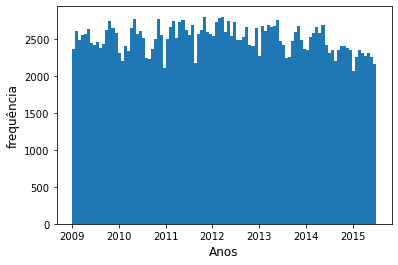

In [134]:
# Exibe um histograma com 100 divisões
plt.hist(key, bins = 100);
plt.xlabel('Anos', size = 12)
plt.ylabel('frequência', size = 12);

In [135]:
# Armazena apenas os dados da coluna pickup_datetime e faz análise descritiva dos dados
pdt = train['pickup_datetime']
pdt.describe()

C:\Users\Geanderson.GEANDERSON-MICH\AppData\Local\Temp\ipykernel_7416\3962246744.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  pdt.describe()


count                        250000
unique                       244650
top       2009-05-15 19:18:00+00:00
freq                              4
first     2009-01-01 00:37:17+00:00
last      2015-06-30 23:59:45+00:00
Name: pickup_datetime, dtype: object

In [136]:
# Análise descritiva dos dados
pdt.describe(datetime_is_numeric=True)

count                                 250000
mean     2012-03-18 23:00:58.285372160+00:00
min                2009-01-01 00:37:17+00:00
25%                2010-08-16 21:54:15+00:00
50%         2012-03-14 23:15:45.500000+00:00
75%         2013-10-17 21:00:29.500000+00:00
max                2015-06-30 23:59:45+00:00
Name: pickup_datetime, dtype: object

In [137]:
# Retira a informação de milissegundos da coluna pickup_datetime
pdt = pdt.map(lambda date: date.tz_localize(None))

In [138]:
# Exibe as 5 primeiras linhas da série pdt
pdt.head()

0   2011-06-21 16:15:00
1   2009-06-06 23:56:00
2   2012-04-25 16:19:00
3   2009-09-02 05:18:10
4   2011-09-24 22:57:00
Name: pickup_datetime, dtype: datetime64[ns]

In [139]:
# Retira a informação de milissegundos da coluna key 
key = pd.to_datetime(key.dt.strftime('%Y-%m-%d %H:%M:%S'))

In [140]:
# Exibe as 5 primeiras linhas da série key
key.head()

0   2011-06-21 16:15:00
1   2009-06-06 23:56:00
2   2012-04-25 16:19:00
3   2009-09-02 05:18:10
4   2011-09-24 22:57:00
Name: key, dtype: datetime64[ns]

In [141]:
# Faz o comparativo para verificar se a coluna key e pickup_datetime são iguais
(key == pdt).value_counts()

True    250000
dtype: int64

**Como as colunas <font color = 'red'>key</font> e <font color='red'>pdt</font> são iguais, vale a pena deletar uma delas para limpar a base de dados**

In [142]:
# Deleta a coluna key da base de dados
train.drop(['key'], axis = 1, inplace = True)

In [143]:
# Exibe as 5 primeiras linhas da base de dados, mas agora sem a coluna key
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.300000,2011-06-21 16:15:00+00:00,-73.991875,40.754436,-73.977226,40.774323,3
1,5.700000,2009-06-06 23:56:00+00:00,-73.982353,40.762497,-73.973213,40.755344,2
2,5.300000,2012-04-25 16:19:00+00:00,-73.971916,40.759251,-73.962906,40.772160,1
3,25.700001,2009-09-02 05:18:10+00:00,-73.991730,40.760502,-73.861244,40.767620,1
4,4.100000,2011-09-24 22:57:00+00:00,-74.000687,40.742237,-74.000359,40.735275,2


In [144]:
# Salva a coluna pickup_datetime com o novo formato (sem a info de milissegundos)
train['pickup_datetime'] = pdt

In [145]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.300000,2011-06-21 16:15:00,-73.991875,40.754436,-73.977226,40.774323,3
1,5.700000,2009-06-06 23:56:00,-73.982353,40.762497,-73.973213,40.755344,2
2,5.300000,2012-04-25 16:19:00,-73.971916,40.759251,-73.962906,40.772160,1
3,25.700001,2009-09-02 05:18:10,-73.991730,40.760502,-73.861244,40.767620,1
4,4.100000,2011-09-24 22:57:00,-74.000687,40.742237,-74.000359,40.735275,2


### 4.2 - Verificação e tratamento das coordenadas - coluna pickup_longitude

In [146]:
# Armazena apenas os dados da coluna pickup_longitude e faz análise descritiva dos dados
plon = train['pickup_longitude']
plon.describe()

count    250000.000000
mean        -72.528488
std          15.740434
min       -3384.713135
25%         -73.992073
50%         -73.981812
75%         -73.967024
max        2889.983887
Name: pickup_longitude, dtype: float64

* **Longitude negativa = Oeste (em inglês, West);**
* **Longitude positiva = Leste (em inglês, East)**

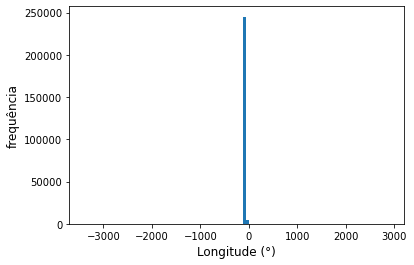

In [147]:
# Exibe um histograma com 100 divisões
plt.hist(plon, bins = 100);
plt.xlabel('Longitude (°)', size = 12)
plt.ylabel('frequência', size = 12);

**Há valores inconsistentes de longitude na coluna <font color='red'>pickup_longitude</font>. Essa ideia pode ser justificada pela presença de valores muito grandes (valor máximo para a longitude de 2889.983887) e muito pequenos (valor mínimo para a longitude de -3384.713135). É necessário ter em mente que, no globo terrestre, a longitude varia de -180 (direção oeste) a 180 (direção leste), onde a referência é o Meridiano de Greenwich (longitude = 0°).**

In [148]:
# Valor da longitude mediana
plon.median() 

-73.9818115234375

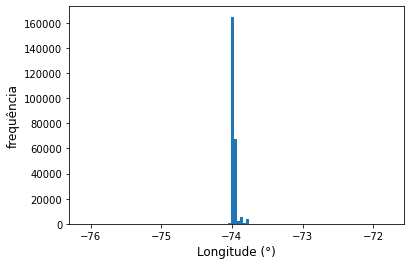

In [149]:
# Exibe um histograma com valores entre (mediana - 2.5) e (mediana + 2.5)
plt.hist(plon[(plon > plon.median() - 2.5) & (plon < plon.median() + 2.5)], bins = 100);
plt.xlabel('Longitude (°)', size = 12)
plt.ylabel('frequência', size = 12);

In [150]:
# Armazena valores entre (mediana - 0.5) e (mediana + 0.5)
plon_val = (plon > plon.median() - 0.5) & (plon < plon.median() + 0.5)

In [151]:
# Conta valores dentro do intervalo (mediana - 0.5) e (mediana + 0.5) e os valores fora desse intervalo
# Valores dentro do intervalo = True; valores fora do intervalo = False
plon_val.value_counts()

True     244905
False      5095
Name: pickup_longitude, dtype: int64

In [152]:
# Exibe a contagem absoluta e a relativa dos valores dentro e fora do intervalo previamente definido
print(plon_val.value_counts(), '\n\n', plon_val.value_counts(normalize = True))

True     244905
False      5095
Name: pickup_longitude, dtype: int64 

 True     0.97962
False    0.02038
Name: pickup_longitude, dtype: float64


**Os <font color='red'>valores inconsistentes serão removidos</font> da base de dados posteriormente**

### 4.3 - Verificação e tratamento das coordenadas - coluna pickup_latitude

In [153]:
# Armazena apenas os dados da coluna pickup_latitude e faz análise descritiva
plat = train['pickup_latitude']
plat.describe()

count    250000.000000
mean         39.972263
std           8.903992
min       -2108.157715
25%          40.734966
50%          40.752640
75%          40.767147
max        1978.489990
Name: pickup_latitude, dtype: float64

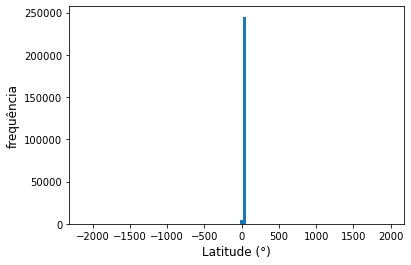

In [154]:
# Exibe um histograma
plt.hist(plat, bins = 100);
plt.xlabel('Latitude (°)', size = 12)
plt.ylabel('frequência', size = 12);

**Há valores inconsistentes de latitude na coluna <font color='red'>pickup_latitude</font>. Essa ideia pode ser justificada pela presença de valores muito grandes (valor máximo para a latitude de 1978.489990) e muito pequenos (valor mínimo para a latitude de -2108.157715). É necessário ter em mente que, no globo terrestre, a latitude varia de -90 (polo sul) a 90 (polo norte), onde a referência é a linha do equador (latitude = 0°).**

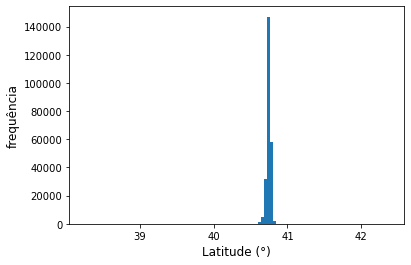

In [155]:
# Exibe um histograma com valores entre (mediana - 2.5) e (mediana + 2.5)
plt.hist(plat[(plat > plat.median() - 2.5) & (plat < plat.median() + 2.5)], bins = 100);
plt.xlabel('Latitude (°)', size = 12)
plt.ylabel('frequência', size = 12);

In [156]:
# Armazena valores entre (mediana - 0.5) e (mediana + 0.5)
# Exibe a contagem absoluta e a relativa dos valores dentro e fora do intervalo previamente definido
plat_val = (plat > plat.median() - 0.5) & (plat < plat.median() + 0.5)
print(plat_val.value_counts(), '\n', plat_val.value_counts(normalize = True))

True     244945
False      5055
Name: pickup_latitude, dtype: int64 
 True     0.97978
False    0.02022
Name: pickup_latitude, dtype: float64


**Esses <font color='red'>valores inconsistentes</font> também <font color='red'>serão removidos</font> da base de dados posteriormente**

### 4.4 - Verificação e tratamento das coordenadas - coluna dropoff_longitude

In [157]:
# Armazena apenas os dados da coluna dropoff_longitude e faz análise descritiva
dlon = train['dropoff_longitude']
dlon.describe()

count    250000.000000
mean        -72.546288
std          14.218449
min       -3047.714844
25%         -73.991402
50%         -73.980103
75%         -73.963638
max        2554.397217
Name: dropoff_longitude, dtype: float64

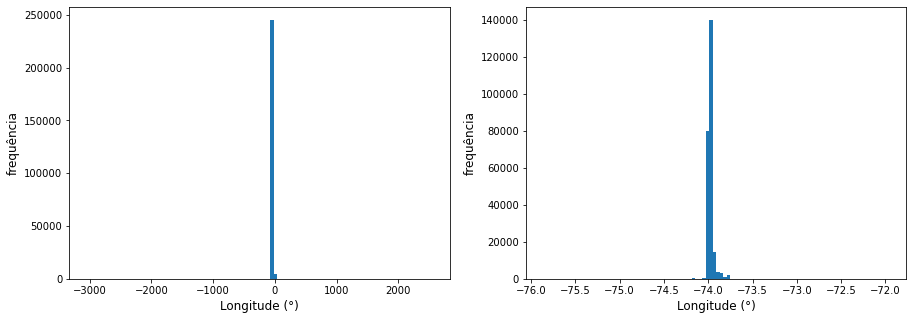

In [158]:
# Exibe dois histogramas: um deles com todos os valores de dropoff_longitude e outro com valores no intervalo (mediana +ou- 2.5)
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].hist(dlon, bins = 100)
ax[0].set_xlabel('Longitude (°)', size = 12)
ax[0].set_ylabel('frequência', size = 12);

ax[1].hist(dlon[(dlon > dlon.median() - 2.5) & (dlon < dlon.median() + 2.5)], bins = 100);
ax[1].set_xlabel('Longitude (°)', size = 12)
ax[1].set_ylabel('frequência', size = 12);

**Existem também valores inconsistentes da longitude de desembarque. As inconsistências são análogas ao exposto na subseção 4.2**

In [159]:
# Armazena valores entre (mediana - 0.5) e (mediana + 0.5)
# Exibe a contagem absoluta e a relativa dos valores dentro e fora do intervalo previamente definido
dlon_val = (dlon > dlon.median() - 0.5) & (dlon < dlon.median() + 0.5)
print(dlon_val.value_counts(), '\n\n', dlon_val.value_counts(normalize = True))

True     244950
False      5050
Name: dropoff_longitude, dtype: int64 

 True     0.9798
False    0.0202
Name: dropoff_longitude, dtype: float64


**Esses <font color='red'>valores inconsistentes</font> também <font color='red'>serão removidos</font> da base de dados posteriormente**

### 4.5 - Verificação e tratamento das coordenadas - coluna dropoff_latitude

In [160]:
# Armazena apenas os dados da coluna dropoff_latitude e faz análise descritiva dos dados
dlat = train['dropoff_latitude']
dlat.describe()

count    250000.000000
mean         39.981991
std          10.486096
min       -2450.704834
25%          40.734032
50%          40.753296
75%          40.768162
max        2561.559082
Name: dropoff_latitude, dtype: float64

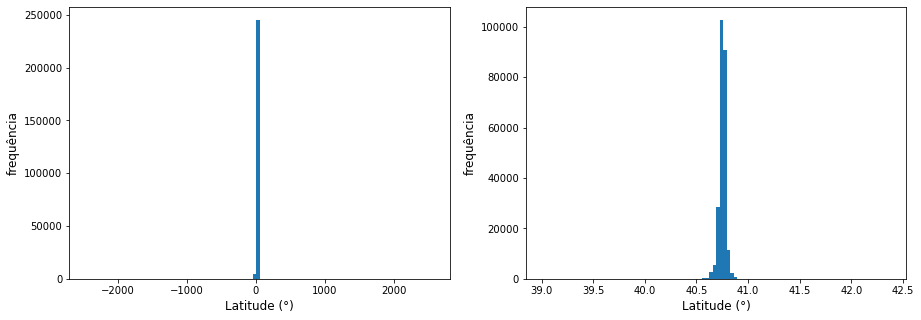

In [161]:
# Exibe dois histogramas: um deles com todos os valores de dropoff_latitude e outro com valores no intervalo (mediana +ou- 2.5)
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].hist(dlat, bins = 100)
ax[0].set_xlabel('Latitude (°)', size = 12)
ax[0].set_ylabel('frequência', size = 12);

ax[1].hist(dlat[(dlat > dlat.median() - 2.5) & (dlat < dlat.median() + 2.5)], bins = 100);
ax[1].set_xlabel('Latitude (°)', size = 12)
ax[1].set_ylabel('frequência', size = 12);

**Existem também valores inconsistentes da latitude de desembarque. As inconsistências são análogas ao exposto na subseção 4.3**

In [162]:
# Armazena valores entre (mediana - 0.5) e (mediana + 0.5)
# Exibe a contagem absoluta e a relativa dos valores dentro e fora do intervalo previamente definido
dlat_val = (dlat > dlat.median() - 0.5) & (dlat < dlat.median() + 0.5)
print(dlat_val.value_counts(), '\n', dlat_val.value_counts(normalize = True))

True     244964
False      5036
Name: dropoff_latitude, dtype: int64 
 True     0.979856
False    0.020144
Name: dropoff_latitude, dtype: float64


**Os <font color='red'>valores inconsistentes</font> também <font color='red'>serão removidos</font> da base de dados posteriormente**

### 4.6 - Verificação e tratamento dos valores inteiros - coluna passenger_count

In [163]:
# Armazena apenas os dados da coluna passenger_count e faz análise descritiva dos dados
pcnt = train['passenger_count']
pcnt.describe()

count    250000.000000
mean          1.688128
std           1.375412
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         208.000000
Name: passenger_count, dtype: float64

**Pode-se observar que há inconsistências na coluna <font color='red'>passenger_count</font>. Há valores grandes de passageiros dentro dos taxis, apresentando um valor máximo de 208 passageiros. Há também uma quantidade mínima de passageiros de 0 na base de dados, e isso não faz sentido.**

In [164]:
# Qntd de viagens com 0 passageiros
len(pcnt == 0)

250000

In [165]:
# Soma a qntd de viagens com 0 passageiros e a média de quantas viagens com 0 passageiros há na base de dados
print((pcnt == 0).sum(),'\n', (pcnt == 0).mean())

861 
 0.003444


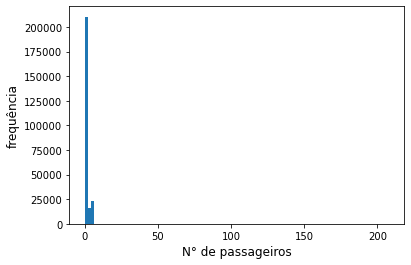

In [166]:
# Exibe um histograma com o n° de passageiros
plt.hist(pcnt, bins = 100);
plt.xlabel('N° de passageiros', size = 12)
plt.ylabel('frequência', size = 12);

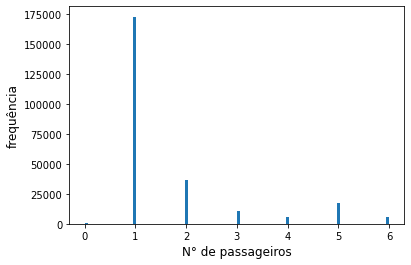

In [167]:
# Plota um histograma com qntd de passageiros < 20 
plt.hist(pcnt[pcnt < 20], bins = 100);
plt.xlabel('N° de passageiros', size = 12)
plt.ylabel('frequência', size = 12);

In [168]:
# Armazena valores no intervalo entre 1 e 6
# Exibe a contagem absoluta e a relativa dos valores dentro e fora do intervalo previamente definido
pcnt_val = (pcnt >= 1) & (pcnt <= 6)
print(pcnt_val.value_counts(), '\n\n', pcnt_val.value_counts(normalize = True))

True     249138
False       862
Name: passenger_count, dtype: int64 

 True     0.996552
False    0.003448
Name: passenger_count, dtype: float64


### 4.7 - Verificação e tratamento dos valores float - coluna fare_amount

In [169]:
# Armazena apenas os dados da coluna fare_amount e faz análise descritiva
fare = train['fare_amount']
fare.describe()

count    250000.000000
mean         11.328001
std           9.699137
min          -7.700000
25%           6.000000
50%           8.500000
75%          12.500000
max         400.000000
Name: fare_amount, dtype: float64

**Pode-se observar que há inconsistências na coluna <font color='red'>passenger_count</font>. Há valores negativos para a tarifa do taxi, apresentando um mínimo de -7.70 dólares. Há valores muito grandes também para uma corrida de taxi, com um máximo de 400 dólares**

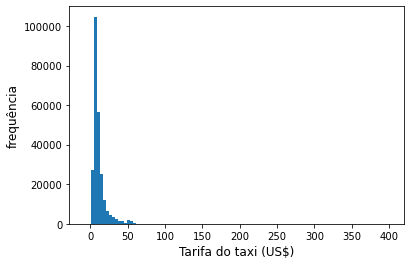

In [170]:
# Plota um histograma
plt.hist(fare, bins = 100)
plt.xlabel('Tarifa do taxi (US$)', size = 12)
plt.ylabel('frequência', size = 12);

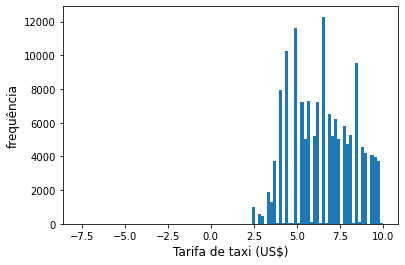

In [193]:
# Plota um histograma com o preço da viagem < 10 dolares
plt.hist(fare[fare < 10], bins = 100);
plt.xlabel('Tarifa de taxi (US$)', size = 12)
plt.ylabel('frequência', size = 12);

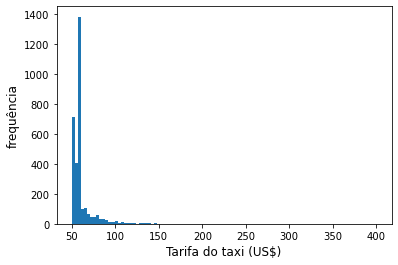

In [172]:
# Plota um histograma com o preço da viagem > 50 dolares
plt.hist(fare[fare > 50], bins = 100);
plt.xlabel('Tarifa do taxi (US$)', size = 12)
plt.ylabel('frequência', size = 12);

In [173]:
# Armazena os preços das viagens no intervalo entre 2 e 150 dolares
# Exibe a contagem absoluta e a relativa dos valores dentro e fora do intervalo previamente definido
fare_val = (fare > 2) & (fare < 150)
print(fare_val.value_counts(), '\n\n', fare_val.value_counts(normalize = True))

True     249963
False        37
Name: fare_amount, dtype: int64 

 True     0.999852
False    0.000148
Name: fare_amount, dtype: float64


### 4.8 - União das variáveis

In [174]:
# Armazena todos os valores que passaram pelos filtros em etapas anteriores
val_entries = fare_val & plon_val & plat_val & dlon_val & dlat_val & pcnt_val

In [175]:
# Exibe a contagem absoluta e a relativa dos valores filtrados (True) e dos valores a serem apagados (False)
print(val_entries.value_counts(), '\n\n', val_entries.value_counts(normalize = True))

True     243718
False      6282
dtype: int64 

 True     0.974872
False    0.025128
dtype: float64


**A quantidade de registros que será apagada é 6.282 (2.51% da base total), enquanto que a quantidade que permanecerá na base de dados é 243.718 (97.49% da base total)**

In [176]:
# Apaga os registros iguais a False, isto é, rejeitados pelos filtros feitos anteriormente em cada coluna
train = train.drop(val_entries[val_entries == False].index)

In [177]:
# Exibe as 5 primeiras linhas
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.300000,2011-06-21 16:15:00,-73.991875,40.754436,-73.977226,40.774323,3
1,5.700000,2009-06-06 23:56:00,-73.982353,40.762497,-73.973213,40.755344,2
2,5.300000,2012-04-25 16:19:00,-73.971916,40.759251,-73.962906,40.772160,1
3,25.700001,2009-09-02 05:18:10,-73.991730,40.760502,-73.861244,40.767620,1
4,4.100000,2011-09-24 22:57:00,-74.000687,40.742237,-74.000359,40.735275,2


In [178]:
# Exibe a qntd de linhas e colunas após o tratamento dos dados
train.shape

(243718, 7)

## 5 - Engineering features

**Entende-se que os dois fatores que mais importam na tarifa do táxi é a duração da corrida e a distância.**

### Duração

**A duração da viagem não é dada e não pode ser calculada porque a hora de chegada não é dada. Isso faz sentido porque a intenção do modelo é prever a tarifa <font color='red'>antes</font> da viagem acontecer.**

**Algo que influencia a duração da viagem é a condição do tráfego. Pode-se deduzir a condição do tráfego usando os dados da coluna <font color='red'>pickup_datetime</font>.**

* **<font color='red'>hora do dia</font>: tráfego será menor durante a noite**
* **<font color='red'>dia da semana</font>: tráfego será menor nos finais de semana**
* **<font color='red'>dia do ano</font>: feriados e férias podem alterar as condições do tráfego e a demanda por taxi, por exemplo**
* **<font color='red'>ano</font>: as viagens podem ser influenciadas por mudanças nas regras de transporte ou inflação**

### 5.1 - Extração de horas do dia, dias da semana, dias do ano e ano da coluna pickup_datetime

In [179]:
# Extrai a hora do dia dos dados da coluna pickup_datetime
train['hour_of_day'] = train['pickup_datetime'].map(lambda date: date.timetuple().tm_hour)

In [180]:
# Exibe as 5 primeiras linhas do dataframe train
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day
0,7.300000,2011-06-21 16:15:00,-73.991875,40.754436,-73.977226,40.774323,3,16
1,5.700000,2009-06-06 23:56:00,-73.982353,40.762497,-73.973213,40.755344,2,23
2,5.300000,2012-04-25 16:19:00,-73.971916,40.759251,-73.962906,40.772160,1,16
3,25.700001,2009-09-02 05:18:10,-73.991730,40.760502,-73.861244,40.767620,1,5
4,4.100000,2011-09-24 22:57:00,-74.000687,40.742237,-74.000359,40.735275,2,22


In [181]:
# Extrai dia da semana, dia do ano e ano
train['day_of_week'] = train['pickup_datetime'].map(lambda date: date.timetuple().tm_wday)
train['day_of_year'] = train['pickup_datetime'].map(lambda date: date.timetuple().tm_yday)
train['year'] = train['pickup_datetime'].map(lambda date: date.timetuple().tm_year)

In [182]:
# Exibe as 5 primeiras linhas do dataframe train
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,day_of_week,day_of_year,year
0,7.300000,2011-06-21 16:15:00,-73.991875,40.754436,-73.977226,40.774323,3,16,1,172,2011
1,5.700000,2009-06-06 23:56:00,-73.982353,40.762497,-73.973213,40.755344,2,23,5,157,2009
2,5.300000,2012-04-25 16:19:00,-73.971916,40.759251,-73.962906,40.772160,1,16,2,116,2012
3,25.700001,2009-09-02 05:18:10,-73.991730,40.760502,-73.861244,40.767620,1,5,2,245,2009
4,4.100000,2011-09-24 22:57:00,-74.000687,40.742237,-74.000359,40.735275,2,22,5,267,2011


In [183]:
# Conta todos as datas que sejam do mês/dia 02-29
len(train['pickup_datetime'][train['pickup_datetime'].dt.strftime('%m-%d') == '02-29'])

117

In [184]:
# Apaga os registros do mês/dia 02-29
train.drop(train['pickup_datetime'][train['pickup_datetime'].dt.strftime('%m-%d') == '02-29'].index,
           inplace = True)

In [185]:
train.shape

(243601, 11)

In [186]:
# A partir do dia 29/02, cada dia do ano sofrerá uma subtração de 1 dia, porque 2012 é ano bissexto
condition = (train['year'] == 2012) & (train['day_of_year'] > 59)
train.loc[condition, 'day_of_year'] = train['day_of_year'] - 1
#train['day_of_year'][condition] = train['day_of_year'] - 1

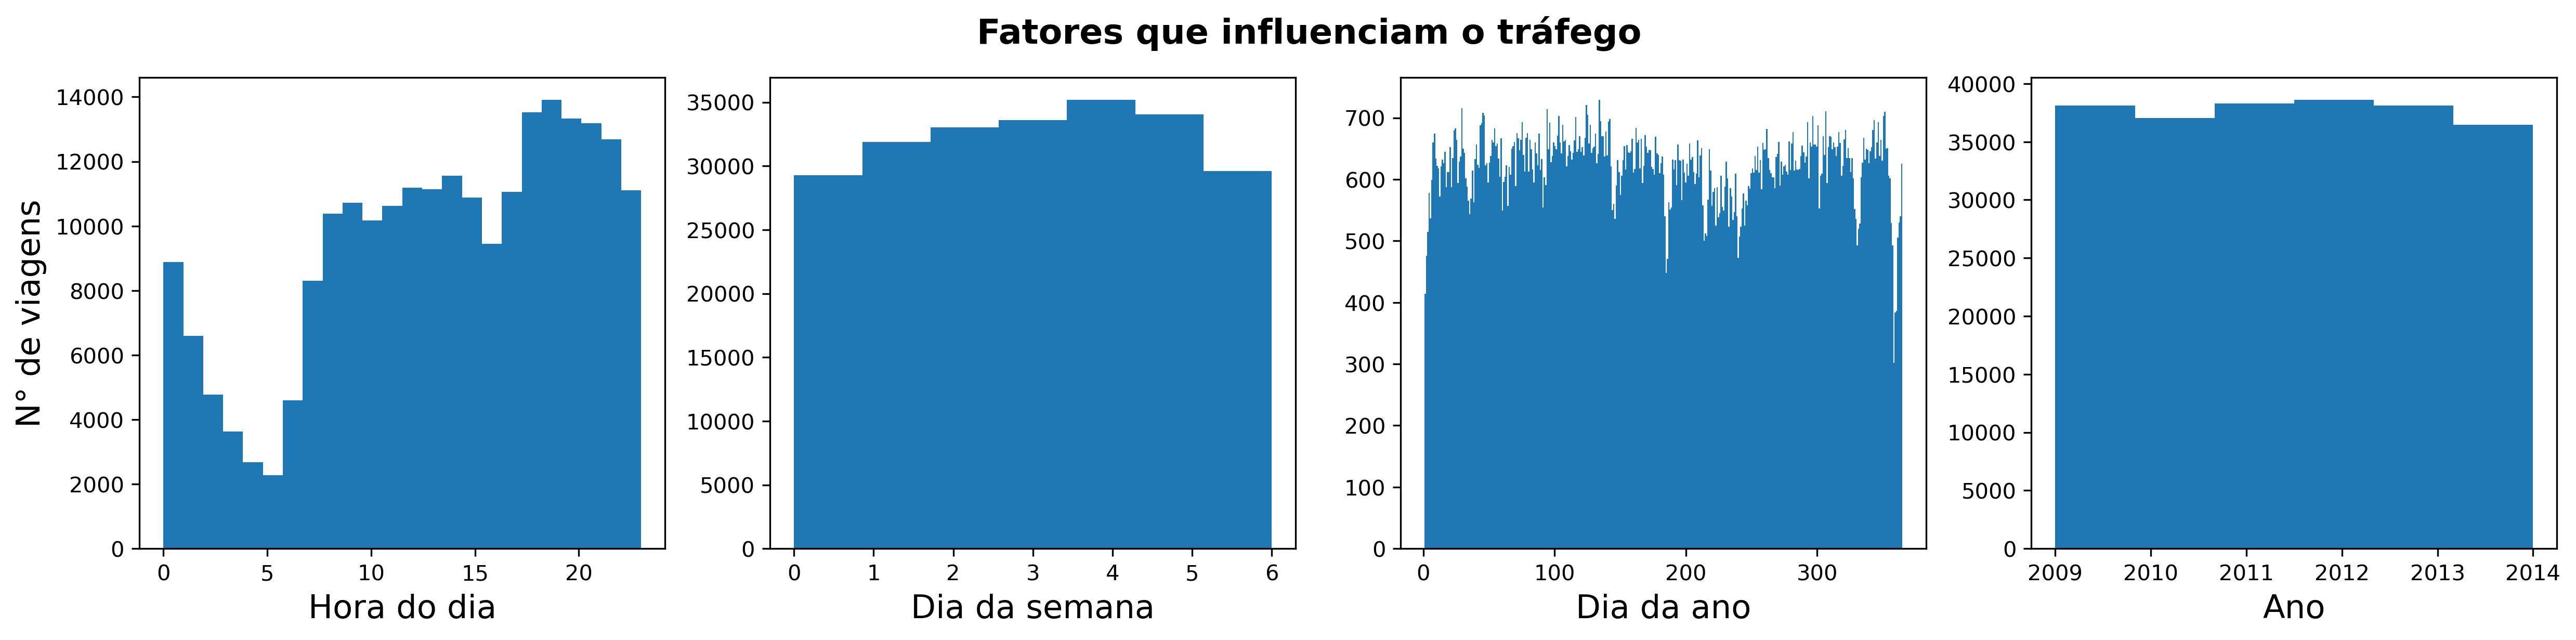

In [187]:
# Plota 4 histogramas dos dados: hora do dia, dias da semana, dias do ano e ano 
fig, ax = plt.subplots(1, 4, figsize = (20,4), dpi = 300)
fig.suptitle(t = 'Fatores que influenciam o tráfego', size = 16, fontweight = 'bold')
#fig.tight_layout()
fig.subplots_adjust(top=0.88)

train_not_2015 = train[train['year'] < 2015] # Os dados de 2015 só vão até metade do ano
ax[0].hist(train_not_2015['hour_of_day'], bins = 24)
ax[0].set_xlabel('Hora do dia', size = 15)
ax[0].set_ylabel('N° de viagens', size = 15);

ax[1].hist(train_not_2015['day_of_week'], bins = 7)
ax[1].set_xlabel('Dia da semana', size = 15)

ax[2].hist(train_not_2015['day_of_year'], bins = 365)
ax[2].set_xlabel('Dia da ano', size = 15)

ax[3].hist(train_not_2015['year'], bins = 6)
ax[3].set_xlabel('Ano', size = 15);

**Pode-se notar que**

* **<font color='red'>Hora do Dia</font>: a quantidade de viagens de taxi cai, a partir das 19h, com mínimo em 5h; os horários de 18h e 19h são os horários com mais viagens;**
* **<font color='red'>Dia da Semana</font>: os dias de domingo (7a barra) e segunda (1a barra) são os dias com menos viagens de taxi; os dias de sexta-feira (5a barra) e sábado (6a barra) são os dias com mais viagens de taxi;**
* **<font color='red'>Dia do Ano</font>: os dias do ano com menos viagens estão entre os meses de julho e agosto;**
* **<font color='red'>Ano</font>: a distribuição do ano é mais uniforme, com poucas diferenças.**

### 5.2 - Relações entre pickup_datetime e o valor pago pela corrida (*fair amount*)

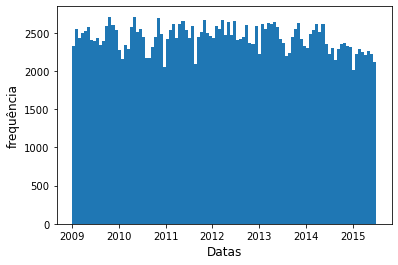

In [190]:
# Exibe um histograma dos dados da coluna pickup_datetime
plt.hist(train['pickup_datetime'], bins = 100);
plt.xlabel('Datas', size = 12)
plt.ylabel('frequência', size = 12);

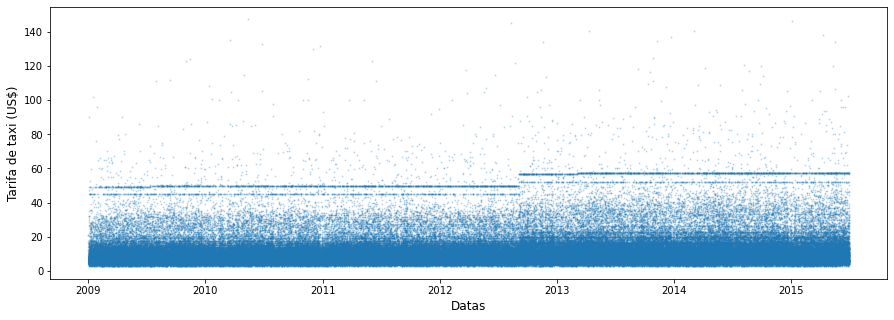

In [194]:
# Exibe um scatterplot usando os dados das coluna pickup_datetime e fare_amount
plt.figure(figsize = (15, 5))
plt.scatter(train['pickup_datetime'], train['fare_amount'], s = 1, alpha = 0.2);
plt.xlabel('Datas', size = 12)
plt.ylabel('Tarifa de taxi (US$)', size = 12);

**Nota-se que há 2 linhas plotadas no gráfico com um comportamento peculiar. Entre 2009 e final de 2012, elas corresponderam a 45 e 50 doláres aproximadamente, enquanto que entre final de 2012 e 2015 essas linhas estão em torno de 50 e 55 dólares. Isso pode ser algum tipo de taxa fixa estabelecida pelo taxista para transpostar os passageiros que, devido a inflação, por exemplo, o valor da taxa aumentou no final de 2012.**

### 5.3 - Contagem dos valores pagos entre 40 e 60 dólares e exibição em um gráfico de barras

In [196]:
# Importa a classe Counter para fazer contagens
from collections import Counter

# Dados filtrados na faixa de valores onde as linhas estão dispostas no gráfico (scatterplot) anterior
fare_zoom = train['fare_amount'][(train['fare_amount'] > 40) & (train['fare_amount'] < 60)]

In [197]:
# Qntd de linhas e colunas de dados
fare_zoom.shape

(5993,)

In [198]:
# Faz a contagem de cada valor filtrado e salvo na variável fare_zoom
common_fares_zoom = Counter(fare_zoom)

In [199]:
# Salva os 10 registros de maior frequência
most_common_fares_zoom = common_fares_zoom.most_common(10)

In [200]:
# Exibe os 10 registros
most_common_fares_zoom

[(57.33000183105469, 1059),
 (49.79999923706055, 732),
 (45.0, 673),
 (49.56999969482422, 498),
 (52.0, 415),
 (56.79999923706055, 231),
 (57.540000915527344, 163),
 (49.150001525878906, 142),
 (40.5, 74),
 (50.5, 62)]

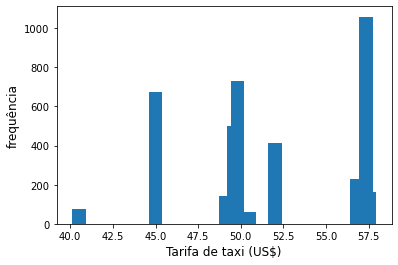

In [202]:
# Captura o primeiro e o segundo valor, separadamente, presentes na variável most_common_fares_zoom
# Após isso, exibe um gráfico de barras
plt.bar([x[0] for x in most_common_fares_zoom], [x[1] for x in most_common_fares_zoom])
plt.xlabel('Tarifa de taxi (US$)', size = 12)
plt.ylabel('frequência', size = 12);

**Pode-se verificar que as barras entre**

* **os valores 45 e 50 dólares representam os valores das linhas compreendidas no intervalo de 2009 a final de 2012;**

* **os valores de 52.50 e 57.50 doláres representam os valores das linhas compreendidas no intervalo de final de 2012 a 2015.**

### 5.4 - Mapa das viagens ocorridas

**Exemplos de uso do parâmetro zorder: https://matplotlib.org/2.0.2/examples/pylab_examples/zorder_demo.html**

In [203]:
# Importa a classe Basemap para criação de mapa
from mpl_toolkits.basemap import Basemap

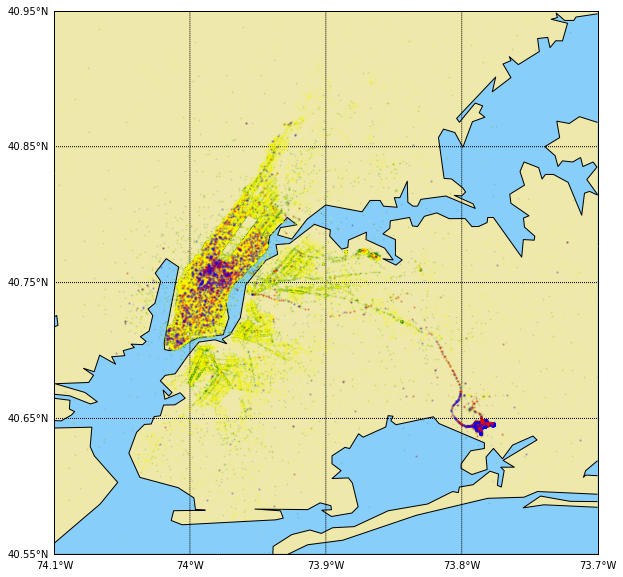

In [204]:
# Definição da latitude e longitude de NYC
lat1, lat2 = 40.55, 40.95
lon1, lon2 = -74.10, -73.70

plt.figure(figsize = (10, 10))
m = Basemap(projection = 'cyl', resolution = 'h', # Projeção cilíndrica e resolução alta para o mapa
            llcrnrlat = lat1, urcrnrlat = lat2, # lat1 e lat2 são as latitudes inferior e superior do mapa, resp.
            llcrnrlon = lon1, urcrnrlon = lon2) # lon1 e lon2 são as longitudes à esquerda e à direita no mapa, resp.
m.drawcoastlines() # Desenha as linhas da costa
m.fillcontinents(color = 'palegoldenrod') # cor do continente = dourado
m.drawmapboundary(fill_color = 'lightskyblue') # cor do lago = azul claro

# exibe os valores de latitudes no intervalo desejado, com step de 0.1
m.drawparallels(np.arange(lat1, lat2 + 0.05, 0.1), labels = [1, 0, 0, 0])# Valores de lats no intervalo desejado, c/ step de 0.1
m.drawmeridians(np.arange(lon1, lon2 + 0.05, 0.1), labels = [0, 0, 0, 1])# Similar a linha anterior, mas para longitudes

# Pickup locations de todas as partídas das viagens de taxi (cor dos pontos: verde)
m.scatter(train['pickup_longitude'], train['pickup_latitude'], s = 1, c = 'green',
          alpha = 0.1, zorder = 5)
# Drop-off locations - de todos os desembarques das viagens de taxi (cor dos pontos: amarelo)
m.scatter(train['dropoff_longitude'], train['dropoff_latitude'], s = 1, c='yellow',
         alpha = 0.1, zorder = 5)

for i in [0, 1, 2, 4]:
    this_fare = most_common_fares_zoom[i][0] # Captura os valores das maiores taxas pagas, mas apenas na posição i
    this_df = train[train['fare_amount'] == this_fare] # armazena todas as informações da viagem que custou a taxa "this_fare"
    
    # pickup location das maiores taxas salvas anteriormente - vermelha
    m.scatter(this_df['pickup_longitude'], this_df['pickup_latitude'], s = 2, c = 'red',
              alpha = 0.2, zorder = 5)
    
    # dropoff location das maiores taxas salvas anteriormente - azul
    m.scatter(this_df['dropoff_longitude'], this_df['dropoff_latitude'], s = 2, c = 'blue',
              alpha = 0.2, zorder = 5)  

## MAPA de NY / Google Maps

<img src="mapa_NY.jpg" alt="Mapa de NY">

**Verifica-se que a maior parte das corridas se encontram entre o centro de Manhattan e o aeroporto internacional John F. Kennedy**

In [205]:
# Armazena todas as lats e lons de desembarque na região próxima ao aeroporto, com alta concentração de pontos azul-escuros
coords = train[['dropoff_latitude',
                'dropoff_longitude']][(train['fare_amount'] > 40) &  # Os valores pagos filtrados estão entre 40 e 60 dólares
                                       (train['fare_amount'] < 60) &
                                       (train['dropoff_latitude'] < 40.7) &
                                       (train['dropoff_latitude'] > 40.6) &
                                       (train['dropoff_longitude'] < -73.7) &
                                       (train['dropoff_longitude'] > -73.9)]

In [206]:
# Exibe a qntd de linhas e colunas
coords.shape

(1612, 2)

In [207]:
# Exibe as 5 primeiras linhas
coords.head()

,dropoff_latitude,dropoff_longitude
140,40.643787,-73.783150
187,40.643696,-73.783447
300,40.644257,-73.782288
321,40.648746,-73.782425
756,40.648785,-73.782310


In [208]:
# Exibe a mediana das latitudes e longitudes de desembarque
print(coords['dropoff_latitude'].median(), coords['dropoff_longitude'].median())

40.645118713378906 -73.78643798828125


In [209]:
# Armazena todas as lats e lons de desembarque na região central de Manhattan, com alta concentração de pontos azul-escuros
coords = train[['dropoff_latitude',
                'dropoff_longitude']][(train['fare_amount'] > 40) &  # Os valores pagos filtrados estão entre 40 e 60 dólares
                                       (train['fare_amount'] < 60) &
                                       (train['dropoff_latitude'] < 40.85) &
                                       (train['dropoff_latitude'] > 40.7) &
                                       (train['dropoff_longitude'] < -73.9) &
                                       (train['dropoff_longitude'] > -74.1)]

In [210]:
# Exibe a mediana das latitudes e longitudes de desembarque
print(coords['dropoff_latitude'].median(), coords['dropoff_longitude'].median())

40.755348205566406 -73.98301696777344


In [211]:
# Verifica e armazena o número de passageiros e as maiores tarifas (taxas) das viagens na região próxima ao aeroporto.
# Posteriormente será feita uma análise de correlação
filtered = train[['fare_amount', 
                  'passenger_count']][((train['fare_amount'] == most_common_fares_zoom[0][0]) |
                                       (train['fare_amount'] == most_common_fares_zoom[1][0]) |
                                       (train['fare_amount'] == most_common_fares_zoom[2][0]) |
                                       (train['fare_amount'] == most_common_fares_zoom[4][0]))&
                                       (train['fare_amount'] < 60) & 
                                       (train['dropoff_latitude'] < 40.7) & 
                                       (train['dropoff_latitude'] > 40.6) & 
                                       (train['dropoff_longitude'] < -73.7) &
                                       (train['dropoff_longitude'] > -73.9)]

In [212]:
# Exibe a qntd de linhas e colunas
filtered.shape

(1109, 2)

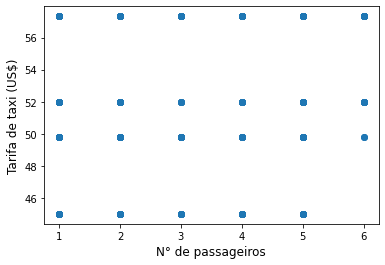

In [214]:
# Exibe um gráfico scatterplot com os valores do número de passageiros e maiores taxas
plt.scatter(filtered['passenger_count'], filtered['fare_amount']);
plt.xlabel('N° de passageiros', size = 12)
plt.ylabel('Tarifa de taxi (US$)', size = 12);

**Pode-se observar que as maiores taxas pagas permanecem constantes, independente do número de passageiros no taxi.**

In [215]:
# Verifica e armazena as maiores tarifas (taxas) das viagens na região próxima ao aeroport,
# além de hora do dia, dia da semana e dia do ano para posterior análise de correlação
filtered = train[['fare_amount', 
                  'hour_of_day',
                  'day_of_week',
                  'day_of_year']][((train['fare_amount'] == most_common_fares_zoom[0][0]) |
                                       (train['fare_amount'] == most_common_fares_zoom[1][0]) |
                                       (train['fare_amount'] == most_common_fares_zoom[2][0]) |
                                       (train['fare_amount'] == most_common_fares_zoom[4][0]))&
                                       (train['fare_amount'] < 60) &
                                       (train['dropoff_latitude'] < 40.7) & 
                                       (train['dropoff_latitude'] > 40.6) & 
                                       (train['dropoff_longitude'] < -73.7) &
                                       (train['dropoff_longitude'] > -73.9)]

In [216]:
# Exibe a qntd de linhas e colunas
filtered.shape

(1109, 4)

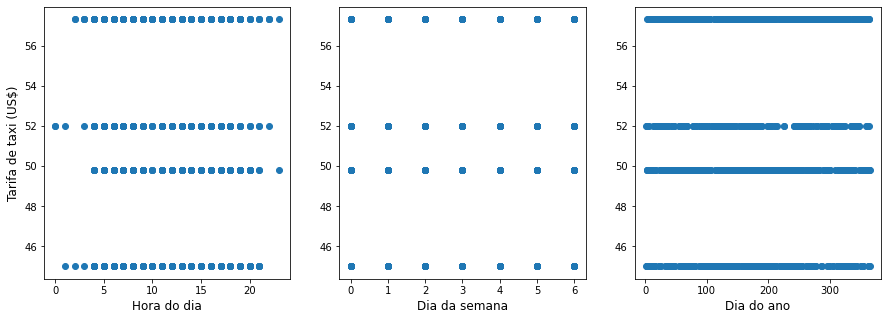

In [218]:
# Plota 3 figuras, relacionando hora do dia e maiores tarifas; dia da semana e maiores tarifas; dia do ano e maiores tarifas.
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].scatter(filtered['hour_of_day'], filtered['fare_amount'])
ax[0].set_xlabel('Hora do dia', size = 12)
ax[0].set_ylabel('Tarifa de taxi (US$)', size = 12);

ax[1].scatter(filtered['day_of_week'], filtered['fare_amount'])
ax[1].set_xlabel('Dia da semana', size = 12);

ax[2].scatter(filtered['day_of_year'], filtered['fare_amount'])
ax[2].set_xlabel('Dia do ano', size = 12);

**Nota-se que independente da hora do dia, dia da semana ou dia do ano, as maiores tarifas permanecem as mesmas.**

### <font color='red'>Conclusão</font>
    
**As <font color='red'>maiores tarifas</font>, pelo menos, <font color='red'>dependem</font> basicamente da <font color='red'>distância percorrida</font> e não da quantidade de passageiros, da hora do dia, dia da semana e do dia do ano.</font>**

In [219]:
# Deleta a coluna 'pickup_datetime' porque já foram criados atributos derivados como hora do dia, dia da semana e dia do ano
train.drop('pickup_datetime', axis = 1, inplace = True)

In [220]:
# Exibe as 5 primeiras linhas
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,day_of_week,day_of_year,year
0,7.300000,-73.991875,40.754436,-73.977226,40.774323,3,16,1,172,2011
1,5.700000,-73.982353,40.762497,-73.973213,40.755344,2,23,5,157,2009
2,5.300000,-73.971916,40.759251,-73.962906,40.772160,1,16,2,115,2012
3,25.700001,-73.991730,40.760502,-73.861244,40.767620,1,5,2,245,2009
4,4.100000,-74.000687,40.742237,-74.000359,40.735275,2,22,5,267,2011


### 5.5 - Cálculo das distâncias euclideana e manhattan

In [221]:
# Faz a conversão dos dados de longitude para outro formato (graus para radianos)
lon1, lon2 = np.radians(train['pickup_longitude']), np.radians(train['dropoff_longitude'])

In [222]:
lon1

0        -1.291402
1        -1.291236
2        -1.291054
3        -1.291399
4        -1.291556
            ...   
249995   -1.291295
249996   -1.291283
249997   -1.291392
249998   -1.291099
249999   -1.291158
Name: pickup_longitude, Length: 243601, dtype: float32

In [223]:
# Faz a conversão dos dados de latitude para outro formato (graus para radianos)
lat1, lat2 = np.radians(train['pickup_latitude']), np.radians(train['dropoff_latitude'])

In [224]:
# Faz um delta entre as latitudes e longitudes de partida e desembarque das viagens de taxi
dlon = lon2 - lon1
dlat = lat2 - lat1

**Fórmula de Haversine: https://pt.wikipedia.org/wiki/F%C3%B3rmula_de_Haversine**

In [225]:
# Distância Euclidiana (Km)
a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
train['eucl_distance'] = 6373 * c

In [226]:
# Exibe as 5 primeiras linhas
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,day_of_week,day_of_year,year,eucl_distance
0,7.300000,-73.991875,40.754436,-73.977226,40.774323,3,16,1,172,2011,2.532987
1,5.700000,-73.982353,40.762497,-73.973213,40.755344,2,23,5,157,2009,1.107720
2,5.300000,-73.971916,40.759251,-73.962906,40.772160,1,16,2,115,2012,1.624382
3,25.700001,-73.991730,40.760502,-73.861244,40.767620,1,5,2,245,2009,11.021216
4,4.100000,-74.000687,40.742237,-74.000359,40.735275,2,22,5,267,2011,0.774648


In [227]:
# Distância Manhattan (Km)
a1 = np.sin(dlon / 2)**2
c1 = 2 * np.arctan2(np.sqrt(a1), np.sqrt(1 - a1))
a2 = np.sin(dlat / 2)**2
c2 = 2 * np.arctan2(np.sqrt(a2), np.sqrt(1 - a2))
train['manh_distance'] = 6373 * (c1 + c2)

In [228]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,day_of_week,day_of_year,year,eucl_distance,manh_distance
0,7.300000,-73.991875,40.754436,-73.977226,40.774323,3,16,1,172,2011,2.532987,3.841528
1,5.700000,-73.982353,40.762497,-73.973213,40.755344,2,23,5,157,2009,1.107720,1.813074
2,5.300000,-73.971916,40.759251,-73.962906,40.772160,1,16,2,115,2012,1.624382,2.438704
3,25.700001,-73.991730,40.760502,-73.861244,40.767620,1,5,2,245,2009,11.021216,15.305335
4,4.100000,-74.000687,40.742237,-74.000359,40.735275,2,22,5,267,2011,0.774648,0.810622


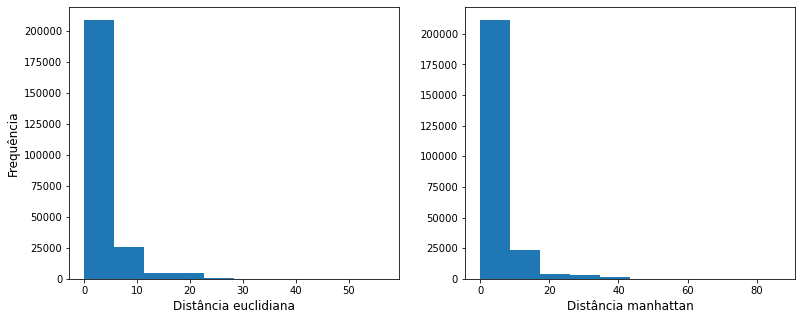

In [231]:
# Faz 2 histogramas: 1 com as distâncias euclidiana (km) e 1 com as distâncias Manhattan (km)
fig, ax = plt.subplots(1, 2, figsize = (13,5))
ax[0].hist(train['eucl_distance'])
ax[0].set_xlabel('Distância euclidiana', size = 12)
ax[0].set_ylabel('Frequência', size = 12)

ax[1].hist(train['manh_distance'])
ax[1].set_xlabel('Distância manhattan', size = 12);

**Observa-se que** 

* **a maioria das distâncias percorridas são de até 5 km nos dois gráficos;**
* **de acordo com os cálculos da distância euclidiana, algumas corridas chegam a aproximadamente 30 km de distância;**
* **de acordo com os cálculos da distância Manhattan, algumas corridas chegam a até 40 km.**

**Essas distâncias serão usadas para o treinamento dos modelos a seguir e será verificada qual dessas distâncias ajudará no melhor treinamento dos modelos.**

## 6 - Pré-processamento

In [232]:
# Deleta apenas a coluna dos valores da base de treinamento de teste a serem previstos
X_reduzida = train.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
                       'dropoff_latitude', 'fare_amount'], axis = 1)

In [233]:
# Deleta apenas a coluna dos valores da base de treinamento de teste a serem previstos
X_completa = train.drop('fare_amount', axis = 1)

In [234]:
# Valores a serem utilizados no treinamento
y = train['fare_amount']

In [235]:
# Exibe as 5 primeiras linhas da base X de treinamento com poucas colunas
X_reduzida.head()

,passenger_count,hour_of_day,day_of_week,day_of_year,year,eucl_distance,manh_distance
0,3,16,1,172,2011,2.532987,3.841528
1,2,23,5,157,2009,1.107720,1.813074
2,1,16,2,115,2012,1.624382,2.438704
3,1,5,2,245,2009,11.021216,15.305335
4,2,22,5,267,2011,0.774648,0.810622


In [236]:
# Exibe as 5 primeiras linhas da base X de treinamento com todas as colunas
X_completa.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,day_of_week,day_of_year,year,eucl_distance,manh_distance
0,-73.991875,40.754436,-73.977226,40.774323,3,16,1,172,2011,2.532987,3.841528
1,-73.982353,40.762497,-73.973213,40.755344,2,23,5,157,2009,1.107720,1.813074
2,-73.971916,40.759251,-73.962906,40.772160,1,16,2,115,2012,1.624382,2.438704
3,-73.991730,40.760502,-73.861244,40.767620,1,5,2,245,2009,11.021216,15.305335
4,-74.000687,40.742237,-74.000359,40.735275,2,22,5,267,2011,0.774648,0.810622


In [237]:
# Exibe alguns registros da base y de treinamento
y

0          7.300000
1          5.700000
2          5.300000
3         25.700001
4          4.100000
            ...    
249995    12.100000
249996     4.900000
249997     4.500000
249998     7.500000
249999    16.500000
Name: fare_amount, Length: 243601, dtype: float32

In [238]:
# Normaliza os dados da base X de treinamento completa
from sklearn.preprocessing import MinMaxScaler
scaler_completa = MinMaxScaler()
scaler_completa.fit(X_completa)
X_completa_minmax = scaler_completa.transform(X_completa)

# Normaliza os dados da base X de treinamento reduzida
from sklearn.preprocessing import MinMaxScaler
scaler_reduzida = MinMaxScaler()
scaler_reduzida.fit(X_reduzida)
X_reduzida_minmax = scaler_reduzida.transform(X_reduzida)

# Padroniza os dados da base X de treinamento completa
from sklearn.preprocessing import StandardScaler
standard_completa = StandardScaler()
standard_completa.fit(X_completa)
X_completa_standard = standard_completa.transform(X_completa)

# Padroniza os dados da base X de treinamento reduzida
from sklearn.preprocessing import StandardScaler
standard_reduzida = StandardScaler()
standard_reduzida.fit(X_reduzida)
X_reduzida_standard = standard_reduzida.transform(X_reduzida)

## 7 - Validação Cruzada

### 7.1 - Seleção de hiperparâmetros

In [239]:
# Importa a classe para a validação cruzada
from sklearn.model_selection import cross_val_score
import time

cv = 10 # Qntd de folds (pedaços da base de dados) para a validação cruzada
scoring = 'neg_mean_squared_error' # Métrica de avaliação de modelo

import multiprocessing
n_jobs = multiprocessing.cpu_count() - 1 # Conta quantos CPU's há disponíveis e usa (qntd de CPU's - 1) para o processamento

random_state = 0

modelos = [] # Armazena os valores de RMSE de cada modelo

**<font color='red'>O objetivo das validações cruzadas a seguir é encontrar o modelo que melhor aprende com os dados (com menor RMSE - Root Mean Squared Error)</font>**

### 7.2 - Implementação de diversos modelos de regressão

### 7.2.1 - Linear Regression

In [105]:
from sklearn.linear_model import LinearRegression

# Armazena o tempo inicial da execução do bloco de código a seguir
tiI = time.time()
for k, x in {'X_completa_minmax': X_completa_minmax, 'X_reduzida_minmax': X_reduzida_minmax,
             'X_completa_stand': X_completa_standard, 'X_reduzida_stand': X_reduzida_standard}.items():
    
    # Configura inteiros randômicos pré-definidos
    np.random.seed(random_state)
    
    # Instancia o modelo 
    model = LinearRegression()
    scores = cross_val_score(model, x, y, cv = cv, scoring = scoring, n_jobs = n_jobs) # Config a validação cruzada
    modelos.append(['Linear Regressor', k, np.sqrt(-scores.mean())]) # Adiciona o RMSE na lista modelos
    
    print(f"Valores Min e Max de MSE para {k}: {(-scores).min(), (-scores).max()}") # scores da validação cruzada (10 folds = 10 scores)
    print()
    print(f"RMSE para {k}: {np.sqrt(-scores.mean())}") # raiz quadrada da média dos 10 scores = root_mean_squared_error
    print()
    
tiF = time.time() # Armazena o tempo final da execução do bloco de código anterior

# Faz a conta tempo final (tiF) - tempo inicial (tiI) e exibe o resultado
print(f'Tempo: {round(tiF-tiI, 1)} seg | Tempo: {round(tiF-tiI, 1)/60} min')

Valores Min e Max de MSE para X_completa_minmax: (19.23250873837917, 22.485732987569932)

RMSE para X_completa_minmax: 4.54414782905299

Valores Min e Max de MSE para X_reduzida_minmax: (19.674086512685847, 22.886090009379405)

RMSE para X_reduzida_minmax: 4.5946100561665615

Valores Min e Max de MSE para X_completa_stand: (19.232508738379185, 22.48573298756996)

RMSE para X_completa_stand: 4.544147829052992

Valores Min e Max de MSE para X_reduzida_stand: (19.67408651268586, 22.886090009379426)

RMSE para X_reduzida_stand: 4.594610056166562

Tempo: 6.9 seg | Tempo: 0.115 min


> ### Modelos Lineares Regularizados
> **Uma forma de reduzir o risco de sobreajuste (em inglês, *overfitting*) é regularizar o modelo, isto é, restringi-lo. Por exemplo, uma forma de regularizar um modelo polinomial é reduzir o número de graus polinomiais. Para um modelo linear, a regularização se da por meio da restrição dos pesos do modelo. Há 3 exemplos de modelos de regressão que apresentam regularizações: Regressão de Ridge, Regressão de Lasso e Elastic Net. A seguir, são implementados os 3 modelos.**

### 7.2.2 - Ridge Regression

**A regressão de Ridge (também conhecida como regularização de Tikhonov) é uma versão regularizada da regressão linear. Um termo de regularização é adicionado à função de custo. O hiperparâmetro alpha controla o quanto você deseja regularizar o modelo. Se alpha = 0, a regressão de Ridge se torna uma simples regressão linear. Se alpha for muito grande, todos os pesos acabarão muito próximos de zero e o resultado será uma linha achatada que passa pela média dos dados.**

In [106]:
from sklearn.linear_model import Ridge

# Armazena o tempo inicial da execução do bloco de código a seguir
tiI = time.time()
for k, x in {'X_completa_minmax': X_completa_minmax, 'X_reduzida_minmax': X_reduzida_minmax,
             'X_completa_stand': X_completa_standard, 'X_reduzida_stand': X_reduzida_standard}.items():
    
    # Configura inteiros randômicos pré-definidos
    np.random.seed(random_state)
    
    # Instancia o modelo 
    model = Ridge()
    scores = cross_val_score(model, x, y, cv = cv, scoring = scoring, n_jobs = n_jobs) # Config a validação cruzada
    modelos.append(['Ridge Regressor', k,np.sqrt(-scores.mean())]) # Adiciona o RMSE na lista modelos
    
    print(f"Valores Min e Max de MSE para {k}: {(-scores).min(), (-scores).max()}") # scores da validação cruzada (10 folds = 10 scores)
    print()
    print(f"RMSE para {k}: {np.sqrt(-scores.mean())}") # raiz quadrada da média dos 10 scores = root_mean_squared_error
    print()
    
tiF = time.time() # Armazena o tempo final da execução do bloco de código anterior

# Faz a conta tempo final (tiF) - tempo inicial (tiI) e exibe o resultado
print(f'Tempo: {round(tiF-tiI, 1)} seg | Tempo: {round(tiF-tiI, 1)/60} min')

Valores Min e Max de MSE para X_completa_minmax: (19.23716637423133, 22.49337320058904)

RMSE para X_completa_minmax: 4.544373559289597

Valores Min e Max de MSE para X_reduzida_minmax: (19.67864934092188, 22.895066237520997)

RMSE para X_reduzida_minmax: 4.594782820903575

Valores Min e Max de MSE para X_completa_stand: (19.232519434086882, 22.485758650622035)

RMSE para X_completa_stand: 4.544147702090856

Valores Min e Max de MSE para X_reduzida_stand: (19.67409869909387, 22.8861224468956)

RMSE para X_reduzida_stand: 4.594609937939951

Tempo: 2.5 seg | Tempo: 0.041666666666666664 min


### 7.2.3 - Lasso Regression

**A regressão de Lasso (Least Absolute Shrinkage and Selection Operator <font color='red'>ou</font> Método de Shrinkage e Seleção de Variáveis) é outra versão regularizada da regressão linear. Assim como a regressão de Ridge, ela adiciona um termo de regularização à função de custo, mas usa a norma l1 do vetor de peso, em vez de metade do quadrado da norma l2.**

In [107]:
from sklearn.linear_model import Lasso

# Armazena o tempo inicial da execução do bloco de código a seguir
tiI = time.time()
for k, x in {'X_completa_minmax': X_completa_minmax, 'X_reduzida_minmax': X_reduzida_minmax,
             'X_completa_stand': X_completa_standard, 'X_reduzida_stand': X_reduzida_standard}.items():
    
    # Configura inteiros randômicos pré-definidos
    np.random.seed(random_state)
    
    # Instancia o modelo 
    model = Lasso()
    scores = cross_val_score(model, x, y, cv = cv, scoring = scoring, n_jobs = n_jobs) # Config a validação cruzada
    modelos.append(['Lasso Regressor', k,np.sqrt(-scores.mean())]) # Adiciona o RMSE na lista modelos
    
    print(f"Valores Min e Max de MSE para {k}: {(-scores).min(), (-scores).max()}") # scores da validação cruzada (10 folds = 10 scores)
    print()
    print(f"RMSE para {k}: {np.sqrt(-scores.mean())}") # raiz quadrada da média dos 10 scores = root_mean_squared_error
    print()
    
tiF = time.time() # Armazena o tempo final da execução do bloco de código anterior

# Faz a conta tempo final (tiF) - tempo inicial (tiI) e exibe o resultado
print(f'Tempo: {round(tiF-tiI, 1)} seg | Tempo: {round(tiF-tiI, 1)/60} min')

Valores Min e Max de MSE para X_completa_minmax: (88.49774344732307, 93.1665977067621)

RMSE para X_completa_minmax: 9.497973074583614

Valores Min e Max de MSE para X_reduzida_minmax: (88.49774344732307, 93.1665977067621)

RMSE para X_reduzida_minmax: 9.497973074583614

Valores Min e Max de MSE para X_completa_stand: (21.651007235103712, 24.705494651054014)

RMSE para X_completa_stand: 4.795745442824875

Valores Min e Max de MSE para X_reduzida_stand: (21.651000409584746, 24.70548558231469)

RMSE para X_reduzida_stand: 4.79574490218318

Tempo: 13.8 seg | Tempo: 0.23 min


### 7.2.4 - Elastic Net

**O modelo Elastic Net é um meio-termo entre a regressão de Ridge e a regressão de Lasso. O termo de regularização é uma simples combinação dos termos de regularização de Ridge e de Lasso. O termo r regulariza o modelo e varia de 0 a 1. Quando r = 0, a Elastic Net é equivalente à regressão de Ridge e quando r = 1 é equivalente à regressão de Lasso. No modelo, o termo r é representado pelo parâmetro l1_ratio.**

In [108]:
from sklearn.linear_model import ElasticNet

# Armazena o tempo inicial da execução do bloco de código a seguir
tiI = time.time()
for k, x in {'X_completa_minmax': X_completa_minmax, 'X_reduzida_minmax': X_reduzida_minmax,
             'X_completa_stand': X_completa_standard, 'X_reduzida_stand': X_reduzida_standard}.items():
    
    # Configura inteiros randômicos pré-definidos
    np.random.seed(random_state)
    
    # Instancia o modelo 
    model = ElasticNet(l1_ratio=0.5)
    scores = cross_val_score(model, x, y, cv = cv, scoring = scoring, n_jobs = n_jobs) # Config a validação cruzada
    modelos.append(['KNN', k,np.sqrt(-scores.mean())]) # Adiciona o RMSE na lista modelos
    
    print(f"Valores Min e Max de MSE para {k}: {(-scores).min(), (-scores).max()}") # scores da validação cruzada (10 folds = 10 scores)
    print()
    print(f"RMSE para {k}: {np.sqrt(-scores.mean())}") # raiz quadrada da média dos 10 scores = root_mean_squared_error
    print()
    
tiF = time.time() # Armazena o tempo final da execução do bloco de código anterior

# Faz a conta tempo final (tiF) - tempo inicial (tiI) e exibe o resultado
print(f'Tempo: {round(tiF-tiI, 1)} seg | Tempo: {round(tiF-tiI, 1)/60} min')

Valores Min e Max de MSE para X_completa_minmax: (88.39180372388306, 93.06503635494808)

RMSE para X_completa_minmax: 9.492455467057088

Valores Min e Max de MSE para X_reduzida_minmax: (88.39180372388306, 93.06503635494808)

RMSE para X_reduzida_minmax: 9.492455467057088

Valores Min e Max de MSE para X_completa_stand: (24.096034363029386, 27.154200496380028)

RMSE para X_completa_stand: 5.037213184349535

Valores Min e Max de MSE para X_reduzida_stand: (24.64994320965971, 27.660364843164277)

RMSE para X_reduzida_stand: 5.090848893346528

Tempo: 4.1 seg | Tempo: 0.06833333333333333 min


### 7.2.5 - K Nearest Neighbors Regressor

In [109]:
from sklearn.neighbors import KNeighborsRegressor

# Armazena o tempo inicial da execução do bloco de código a seguir
tiI = time.time()
for k, x in {'X_completa_minmax': X_completa_minmax, 'X_reduzida_minmax': X_reduzida_minmax,
             'X_completa_stand': X_completa_standard, 'X_reduzida_stand': X_reduzida_standard}.items():
    
    # Configura inteiros randômicos pré-definidos
    np.random.seed(random_state)
    
    # Instancia o modelo 
    model = KNeighborsRegressor()
    scores = cross_val_score(model, x, y, cv = cv, scoring = scoring, n_jobs = n_jobs) # Config a validação cruzada
    modelos.append(['KNN', k,np.sqrt(-scores.mean())]) # Adiciona o RMSE na lista modelos
    
    print(f"Valores Min e Max de MSE para {k}: {(-scores).min(), (-scores).max()}") # scores da validação cruzada (10 folds = 10 scores)
    print()
    print(f"RMSE para {k}: {np.sqrt(-scores.mean())}") # raiz quadrada da média dos 10 scores = root_mean_squared_error
    print()
    
tiF = time.time() # Armazena o tempo final da execução do bloco de código anterior

# Faz a conta tempo final (tiF) - tempo inicial (tiI) e exibe o resultado
print(f'Tempo: {round(tiF-tiI, 1)} seg | Tempo: {round(tiF-tiI, 1)/60} min')

Valores Min e Max de MSE para X_completa_minmax: (22.538856506347656, 25.68451690673828)

RMSE para X_completa_minmax: 4.918751702314419

Valores Min e Max de MSE para X_reduzida_minmax: (23.804489135742188, 26.688386917114258)

RMSE para X_reduzida_minmax: 5.042591878104066

Valores Min e Max de MSE para X_completa_stand: (15.462075233459473, 18.966405868530273)

RMSE para X_completa_stand: 4.12248495475101

Valores Min e Max de MSE para X_reduzida_stand: (20.09478187561035, 23.129356384277344)

RMSE para X_reduzida_stand: 4.6259069017541075

Tempo: 149.1 seg | Tempo: 2.485 min


### 7.2.6 - SVm (SVR)

In [110]:
from sklearn.svm import SVR

# Armazena o tempo inicial da execução do bloco de código a seguir
tiI = time.time()
for k, x in {'X_completa_minmax': X_completa_minmax, 'X_reduzida_minmax': X_reduzida_minmax,
             'X_completa_stand': X_completa_standard, 'X_reduzida_stand': X_reduzida_standard}.items():
    
    # Configura inteiros randômicos pré-definidos
    np.random.seed(random_state)
    
    # Instancia o modelo
    model = SVR()
    scores = cross_val_score(model, x, y, cv = cv, scoring = scoring, n_jobs = n_jobs) # Config a validação cruzada
    modelos.append(['SVR', k,np.sqrt(-scores.mean())]) # Adiciona o RMSE na lista modelos
    
    print(f"Valores Min e Max de MSE para {k}: {(-scores).min(), (-scores).max()}") # scores da validação cruzada (10 folds = 10 scores)
    print()
    print(f"RMSE para {k}: {np.sqrt(-scores.mean())}") # raiz quadrada da média dos 10 scores = root_mean_squared_error
    print()
    
tiF = time.time() # Armazena o tempo final da execução do bloco de código anterior

# Faz a conta tempo final (tiF) - tempo inicial (tiI) e exibe o resultado
print(f'Tempo: {round(tiF-tiI, 1)} seg | Tempo: {round(tiF-tiI, 1)/60} min')

Valores Min e Max de MSE para X_completa_minmax: (17.6342871937767, 20.854292463223487)

RMSE para X_completa_minmax: 4.386176286730865

Valores Min e Max de MSE para X_reduzida_minmax: (18.221368706646107, 21.505924309623285)

RMSE para X_reduzida_minmax: 4.45103955932678

Valores Min e Max de MSE para X_completa_stand: (15.404004113697507, 18.073201309235063)

RMSE para X_completa_stand: 4.073988688949185

Valores Min e Max de MSE para X_reduzida_stand: (18.227134060065307, 21.54269264598653)

RMSE para X_reduzida_stand: 4.449959516441113

Tempo: 83164.5 seg | Tempo: 1386.075 min


### 7.2.7 - Decision Tree Regressor

In [111]:
from sklearn.tree import DecisionTreeRegressor

# Armazena o tempo inicial da execução do bloco de código a seguir
tiI = time.time()
for k, x in {'X_completa_minmax': X_completa_minmax, 'X_reduzida_minmax': X_reduzida_minmax,
             'X_completa_stand': X_completa_standard, 'X_reduzida_stand': X_reduzida_standard}.items():
    
    # Configura inteiros randômicos pré-definidos
    np.random.seed(random_state)
    
    # Instancia o modelo 
    model = DecisionTreeRegressor()
    scores = cross_val_score(model, x, y, cv = cv, scoring = scoring, n_jobs = n_jobs) # Config a validação cruzada
    modelos.append(['Decision Tree', k,np.sqrt(-scores.mean())]) # Adiciona o RMSE na lista modelos
    
    print(f"Valores Min e Max de MSE para {k}: {(-scores).min(), (-scores).max()}") # scores da validação cruzada (10 folds = 10 scores)
    print()
    print(f"RMSE para {k}: {np.sqrt(-scores.mean())}") # raiz quadrada da média dos 10 scores = root_mean_squared_error
    print()
    
tiF = time.time() # Armazena o tempo final da execução do bloco de código anterior

# Faz a conta tempo final (tiF) - tempo inicial (tiI) e exibe o resultado
print(f'Tempo: {round(tiF-tiI, 1)} seg | Tempo: {round(tiF-tiI, 1)/60} min')

Valores Min e Max de MSE para X_completa_minmax: (24.000783961642785, 27.832704706580735)

RMSE para X_completa_minmax: 5.122341504078352

Valores Min e Max de MSE para X_reduzida_minmax: (35.27859496873785, 39.23279860190344)

RMSE para X_reduzida_minmax: 6.0899782858504805

Valores Min e Max de MSE para X_completa_stand: (23.775792591763036, 28.367771908019172)

RMSE para X_completa_stand: 5.130575498661675

Valores Min e Max de MSE para X_reduzida_stand: (34.722158151043104, 38.91583202410793)

RMSE para X_reduzida_stand: 6.074183121925735

Tempo: 48.2 seg | Tempo: 0.8033333333333333 min


### 7.2.8 - Random Forest Regressor

In [112]:
from sklearn.ensemble import RandomForestRegressor

# Armazena o tempo inicial da execução do bloco de código a seguir
tiI = time.time()
for k, x in {'X_completa_minmax': X_completa_minmax, 'X_reduzida_minmax': X_reduzida_minmax,
             'X_completa_stand': X_completa_standard, 'X_reduzida_stand': X_reduzida_standard}.items():
    
    # Configura inteiros randômicos pré-definidos
    np.random.seed(random_state)
    
    # Instancia o modelo 
    model = RandomForestRegressor()
    scores = cross_val_score(model, x, y, cv = cv, scoring = scoring, n_jobs = n_jobs) # Config a validação cruzada
    modelos.append(['Random Forest', k,np.sqrt(-scores.mean())]) # Adiciona o RMSE na lista modelos
    
    print(f"Valores Min e Max de MSE para {k}: {(-scores).min(), (-scores).max()}") # scores da validação cruzada (10 folds = 10 scores)
    print()
    print(f"RMSE para {k}: {np.sqrt(-scores.mean())}") # raiz quadrada da média dos 10 scores = root_mean_squared_error
    print()
    
tiF = time.time() # Armazena o tempo final da execução do bloco de código anterior

# Faz a conta tempo final (tiF) - tempo inicial (tiI) e exibe o resultado
print(f'Tempo: {round(tiF-tiI, 1)} seg | Tempo: {round(tiF-tiI, 1)/60} min')

Valores Min e Max de MSE para X_completa_minmax: (11.878811551383102, 14.326753527817662)

RMSE para X_completa_minmax: 3.6635858852793777

Valores Min e Max de MSE para X_reduzida_minmax: (17.23879044038788, 19.610578624800347)

RMSE para X_reduzida_minmax: 4.289758651471671

Valores Min e Max de MSE para X_completa_stand: (11.860887612629009, 14.342144430146988)

RMSE para X_completa_stand: 3.66414106455947

Valores Min e Max de MSE para X_reduzida_stand: (17.163189645065646, 19.756068756032136)

RMSE para X_reduzida_stand: 4.289529928950596

Tempo: 2971.2 seg | Tempo: 49.519999999999996 min


### 7.2.9 - Gradient Boosting Regressor

In [113]:
from sklearn.ensemble import GradientBoostingRegressor

# Armazena o tempo inicial da execução do bloco de código a seguir
tiI = time.time()
for k, x in {'X_completa_minmax': X_completa_minmax, 'X_reduzida_minmax': X_reduzida_minmax,
             'X_completa_stand': X_completa_standard, 'X_reduzida_stand': X_reduzida_standard}.items():
    
    # Configura inteiros randômicos pré-definidos
    np.random.seed(random_state)
    
    # Instancia o modelo 
    model = GradientBoostingRegressor()
    scores = cross_val_score(model, x, y, cv = cv, scoring = scoring, n_jobs = n_jobs) # Config a validação cruzada
    modelos.append(['GB', k,np.sqrt(-scores.mean())]) # Adiciona o RMSE na lista modelos
    
    print(f"Valores Min e Max de MSE para {k}: {(-scores).min(), (-scores).max()}") # scores da validação cruzada (10 folds = 10 scores)
    print()
    print(f"RMSE para {k}: {np.sqrt(-scores.mean())}") # raiz quadrada da média dos 10 scores = root_mean_squared_error
    print()
    
tiF = time.time() # Armazena o tempo final da execução do bloco de código anterior

# Faz a conta tempo final (tiF) - tempo inicial (tiI) e exibe o resultado
print(f'Tempo: {round(tiF-tiI, 1)} seg | Tempo: {round(tiF-tiI, 1)/60} min')

Valores Min e Max de MSE para X_completa_minmax: (13.011006974781168, 16.200350481867485)

RMSE para X_completa_minmax: 3.802812821547798

Valores Min e Max de MSE para X_reduzida_minmax: (16.44064313271223, 18.97547040222353)

RMSE para X_reduzida_minmax: 4.197445824307118

Valores Min e Max de MSE para X_completa_stand: (13.015769852326304, 16.21673108211693)

RMSE para X_completa_stand: 3.8075090436407844

Valores Min e Max de MSE para X_reduzida_stand: (16.368023344963714, 18.984951089871682)

RMSE para X_reduzida_stand: 4.197326945597167

Tempo: 896.7 seg | Tempo: 14.945 min


### 7.2.10 - XGBoosting

In [114]:
from xgboost import XGBRegressor

# Armazena o tempo inicial da execução do bloco de código a seguir
tiI = time.time()
for k, x in {'X_completa_minmax': X_completa_minmax, 'X_reduzida_minmax': X_reduzida_minmax,
             'X_completa_stand': X_completa_standard, 'X_reduzida_stand': X_reduzida_standard}.items():
    
    # Configura inteiros randômicos pré-definidos
    np.random.seed(random_state)
    
    # Instancia o modelo 
    model = XGBRegressor()
    scores = cross_val_score(model, x, y, cv = cv, scoring = scoring, n_jobs = n_jobs) # Config a validação cruzada
    modelos.append(['XGB', k, np.sqrt(-scores.mean())]) # Adiciona o RMSE na lista modelos
    
    print(f"Valores Min e Max de MSE para {k}: {(-scores).min(), (-scores).max()}") # scores da validação cruzada (10 folds = 10 scores)
    print()
    print(f"RMSE para {k}: {np.sqrt(-scores.mean())}") # raiz quadrada da média dos 10 scores = root_mean_squared_error
    print()
    
tiF = time.time() # Armazena o tempo final da execução do bloco de código anterior

# Faz a conta tempo final (tiF) - tempo inicial (tiI) e exibe o resultado
print(f'Tempo: {round(tiF-tiI, 1)} seg | Tempo: {round(tiF-tiI, 1)/60} min')

Valores Min e Max de MSE para X_completa_minmax: (11.373255729675293, 14.110547065734863)

RMSE para X_completa_minmax: 3.5859287502871875

Valores Min e Max de MSE para X_reduzida_minmax: (16.528486251831055, 19.03870964050293)

RMSE para X_reduzida_minmax: 4.204238142925155

Valores Min e Max de MSE para X_completa_stand: (11.346579551696777, 14.257265090942383)

RMSE para X_completa_stand: 3.591427551830384

Valores Min e Max de MSE para X_reduzida_stand: (16.45651626586914, 19.256608963012695)

RMSE para X_reduzida_stand: 4.201700302366675

Tempo: 401.6 seg | Tempo: 6.693333333333333 min


### 7.3 - Verificação da performance dos modelo

In [116]:
# Cria um dataframe com os dados da lista ModelosK
df = pd.DataFrame(data = modelos, columns = ['Algoritmo', 'Conj. Treinamento', "RMSE"])

# Ordena as linhas pelo valor da RMSE
df.sort_values(by = 'RMSE', ascending = True, inplace = True)

# Reseta os índices do dataframe
df.reset_index(drop = True, inplace = True)

# Exibe os dados do dataframe
df

,Algoritmo,Conj. Treinamento,RMSE
0,XGB,X_completa_minmax,3.585929
1,XGB,X_completa_stand,3.591428
2,Random Forest,X_completa_minmax,3.663586
3,Random Forest,X_completa_stand,3.664141
4,GB,X_completa_minmax,3.802813
5,GB,X_completa_stand,3.807509
6,SVR,X_completa_stand,4.073989
7,KNN,X_completa_stand,4.122485
8,GB,X_reduzida_stand,4.197327
9,GB,X_reduzida_minmax,4.197446


### 8 - Implementação do Grid Search com o modelo selecionado

**Como pode ser observado, o modelo XGB Regressor ficou em 1° lugar entre os modelos que melhor se ajustaram aos dados de treinamento e teste.**<br><br>
**Devido à proximidade dos valores de RMSE para os dados padronizados com a classe MinMaxScaler e os padronizados com a classe StandardScaler, escolheu-se os dados padronizados pela última classe citada para ajustar os hiperparâmetros do modelo XGB Regressor no bloco de código a seguir.**<br><br>
**Apenas alguns hiperparâmetros do modelo foram selecionados para executar o *Grid Search* devido a demora na conclusão da execução do algoritmo quando mais hiperparâmetros são utilizados.**

In [104]:
n_estimators = [100, 200, 500]

In [105]:
gamma = [0, 1, 3, 5]

In [106]:
max_depth = range(6, 11, 2)

In [107]:
max_leaves = range(0, 10, 1)

In [109]:
# Hiperparâmetros que serão testados no algoritmo Grid Search
params_list = [{'n_estimators': n_estimators, 'gamma': gamma, 'max_depth': max_depth, 'max_leaves': max_leaves}]

In [244]:
# Importa o algoritmo XGB Regressor e a classe para Grid Search
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [113]:
# Armazena o tempo inicial da execução do bloco de código a seguir
tiI = time.time()
melhores_parametros = [] # Lista vazia que salvará alguns valores acerca do treinamento de cada variável

# Seleciona os dados com tratamentos diferentes
for k, x in {'X_completa_stand': X_completa_standard}.items():
    
    # Configura inteiros randômicos pré-definidos
    np.random.seed(random_state)
    
    fit_params={"early_stopping_rounds":30, 
            "eval_metric" : "rmse", 
            "eval_set" : [[x, y]]}
    
    model = GridSearchCV(XGBRegressor(eta = 0.1, booster = 'gbtree'), params_list, n_jobs = n_jobs, 
                        verbose = 10, scoring = scoring, cv = cv)
    
    #model = RandomizedSearchCV(XGBRegressor(eta = 0.1, booster = 'gbtree'), params_list, n_jobs = n_jobs, 
                               #verbose = 1, scoring = scoring, cv = cv)
    
    
    # Treina o algoritmo
    #model.fit(x, y, model__eval_set=[[x, y]], model__early_stopping_rounds = 10)
    model.fit(x, y)
    
    print('Melhores parâmetros: {0}\n'.format(model.best_params_)) # Exibe os melhores hiperparams encontrados para o modelo
    medias = np.abs(model.cv_results_['mean_test_score']) # Médias de testes, uma para cada combinação de hiperparâmetro
    ranks = model.cv_results_['rank_test_score'] # Ranks (posições) dos testes, uma para cada combinação de hiperparâmetro
    desvios = model.cv_results_['std_test_score'] # Desvios-padrões de testes, uma para cada combinação de hiperparâmetro
    params_set = model.cv_results_['params'] # Combinações de hiperparâmetros feitos pelo Grid Search
    zipped = zip(ranks, medias, desvios, params_set) # Organiza os dados das variáveis anteriores em tuplas
    sorted_zip = sorted(zipped, key=lambda x: x[0]) # Ordena as tuplas pelos ranks dos testes
    
    # Armazena a string SVM, tipo do tratamento dos dados para o tratamento, média, desvio-padrão e melhores hiperparâmetros
    points = ['XGB Regressor', k, sorted_zip[0][1], np.sqrt(sorted_zip[0][2]), model.best_params_]
    melhores_parametros.append(points) # Adiciona a lista "points" na lista melhores_parametros

tiF = time.time() # Armazena o tempo final da execução do bloco de código anterior

# Faz a conta tempo final (tiF) - tempo inicial (tiI) e exibe o resultado
print(f'Tempo: {round(tiF-tiI, 1)} seg | Tempo: {round(tiF-tiI, 1)/60} min')

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


C:\Users\Geanderson.GEANDERSON-MICH\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Geanderson.GEANDERSON-MICH\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:13.05668
[1]	validation_0-rmse:11.86698
[2]	validation_0-rmse:10.80628
[3]	validation_0-rmse:9.85962
[4]	validation_0-rmse:9.01896
[5]	validation_0-rmse:8.27177
[6]	validation_0-rmse:7.61169
[7]	validation_0-rmse:7.02976
[8]	validation_0-rmse:6.51637
[9]	validation_0-rmse:6.06647
[10]	validation_0-rmse:5.67470
[11]	validation_0-rmse:5.33383
[12]	validation_0-rmse:5.03862
[13]	validation_0-rmse:4.78242
[14]	validation_0-rmse:4.56215
[15]	validation_0-rmse:4.37294
[16]	validation_0-rmse:4.21109
[17]	validation_0-rmse:4.07413
[18]	validation_0-rmse:3.95684
[19]	validation_0-rmse:3.85620
[20]	validation_0-rmse:3.76939
[21]	validation_0-rmse:3.69779
[22]	validation_0-rmse:3.63227
[23]	validation_0-rmse:3.57904
[24]	validation_0-rmse:3.53392
[25]	validation_0-rmse:3.49250
[26]	validation_0-rmse:3.45549
[27]	validation_0-rmse:3.42696
[28]	validation_0-rmse:3.40079
[29]	validation_0-rmse:3.37321
[30]	validation_0-rmse:3.35232
[31]	validation_0-rmse:3.33557
[32]	validation

[260]	validation_0-rmse:2.46241
[261]	validation_0-rmse:2.46112
[262]	validation_0-rmse:2.45787
[263]	validation_0-rmse:2.45456
[264]	validation_0-rmse:2.45224
[265]	validation_0-rmse:2.45112
[266]	validation_0-rmse:2.44904
[267]	validation_0-rmse:2.44833
[268]	validation_0-rmse:2.44752
[269]	validation_0-rmse:2.44560
[270]	validation_0-rmse:2.44505
[271]	validation_0-rmse:2.44203
[272]	validation_0-rmse:2.44027
[273]	validation_0-rmse:2.43912
[274]	validation_0-rmse:2.43764
[275]	validation_0-rmse:2.43596
[276]	validation_0-rmse:2.43144
[277]	validation_0-rmse:2.43074
[278]	validation_0-rmse:2.42756
[279]	validation_0-rmse:2.42574
[280]	validation_0-rmse:2.42541
[281]	validation_0-rmse:2.42502
[282]	validation_0-rmse:2.42346
[283]	validation_0-rmse:2.42292
[284]	validation_0-rmse:2.42211
[285]	validation_0-rmse:2.42033
[286]	validation_0-rmse:2.41886
[287]	validation_0-rmse:2.41492
[288]	validation_0-rmse:2.41429
[289]	validation_0-rmse:2.41262
[290]	validation_0-rmse:2.41162
[291]	va

**Como pode-se notar, o algoritmo *Grid Search* levou quase 2 dias para o termino da sua execução. A melhor combinação de hiperparâmetros é mostrada acima.**<br><br>
**As outras combinações, juntamente com seus valores de *score*, encontradas pelo algoritmo foram salvas em um arquivo denominado Todos_os_parametros_e_scores.xlsx .**<br><br>
**Ao abrir o arquivo Todos_os_parametros_e_scores.xlsx supracitado, é possível notar que os hiperparâmetros mais importantes para o treinamento do modelo são hiperparâmetro <font color='red'>gamma</font> e <font color='red'>n_estimators</font>. Os hiperparâmeros <font color='red'>max_depth</font> e <font color='red'>max_leaves</font> não influenciaram no desempenho do modelo, mesmo quando seus valores foram aumentados.**

## 9 - Treinamento preliminar e inspeção do modelo selecionado

**Nessa seção é feito o treinamento do modelo e, após isso, verifica quais variáveis foram importantes para o treinamento dele**

### 9.1 - Treinamento

In [240]:
# Separa os dados em dados de treinamento e teste na proporção 80%/20%
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_completa_standard, y,
                                                      test_size = 0.2, random_state = random_state)

In [241]:
# Exibe a qntd de linhas e colunas dos dados de treinamento
X_train.shape

(194880, 11)

In [242]:
# Exibe a qntd de linhas e colunas dos dados de teste 
X_test.shape

(48721, 11)

In [245]:
# Treina o modelo
model = XGBRegressor(n_estimators = 501, gamma = 0, max_depth = 10, max_leaves = 10, eta = 0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=10, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=501, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

### 9.2 - Inspeção do modelo

In [112]:
# Armazena as importâncias de cada atributo previsor
features_importances = model.feature_importances_

In [113]:
# Exibe as importâncias
features_importances

array([0.01549627, 0.01250028, 0.03006379, 0.01631933, 0.00791416,
       0.01398024, 0.01085675, 0.01307   , 0.06240305, 0.79216355,
       0.02523257], dtype=float32)

In [114]:
# Armazena os índices de cada importâncias, ordenando-os da MENOR importância para a MAIOR importância
argsort = np.argsort(features_importances)

In [115]:
# Exibe os índices das importâncias
argsort

array([ 4,  6,  1,  7,  5,  0,  3, 10,  2,  8,  9], dtype=int64)

In [116]:
# Ordena os valores das importâncias, do menor valor para o maior
features_importances_sorted = features_importances[argsort]

In [117]:
# Exibe as importâncias ordenadas
features_importances_sorted

array([0.00791416, 0.01085675, 0.01250028, 0.01307   , 0.01398024,
       0.01549627, 0.01631933, 0.02523257, 0.03006379, 0.06240305,
       0.79216355], dtype=float32)

In [125]:
# Armazena o nome das colunas da base de treinamento
feature_names = X_completa.columns

In [126]:
# Exibe o nome das colunas
feature_names

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'hour_of_day', 'day_of_week',
       'day_of_year', 'year', 'eucl_distance', 'manh_distance'],
      dtype='object')

In [127]:
# Armazena as colunas de forma ordenada, da menor para a maior importância
features_sorted = feature_names[argsort]

In [128]:
# Exibe as colunas ordenadas pelas suas importâncias
features_sorted

Index(['passenger_count', 'day_of_week', 'pickup_latitude', 'day_of_year',
       'hour_of_day', 'pickup_longitude', 'dropoff_latitude', 'manh_distance',
       'dropoff_longitude', 'year', 'eucl_distance'],
      dtype='object')

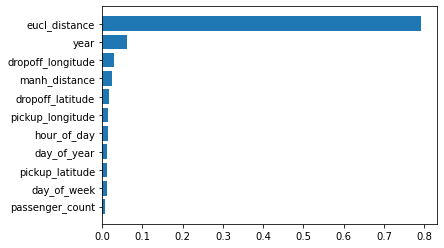

In [129]:
# Plota um gráfico de barras horizontais. Eixo x: colunas ordenadas pelas importâncias; eixo y: importâncias ordenadas
plt.barh(features_sorted, features_importances_sorted);

**Verifica-se que o top 5 dos atributos com maior importância para o aprendizado do modelo XGB Regressor são**
<br><br>
**1. <font color='blue'>distância euclidiana</font>**<br>
**2. <font color='blue'>ano</font>;**<br>
**3. <font color='blue'>longitude de desembarque</font>;**<br>
**4. <font color='blue'>distância Manhattan</font>;**<br>
**5. <font color='blue'>latitude de desembarque</font>.**<br>

## 10 - Treinamento definitivo e previsões na base de dados de teste

**Nessa seção são feitos o treinamento e o teste do modelo e, logo após, na seção 11, é executada a previsão de diversos valores para a tarifa de taxi usando a base de teste obtida da plataforma Kaggle.**

### 10.1 - Treinamento e avaliação do modelo

In [147]:
# Armazena as previsões na base de dados de teste
y_pred = model.predict(X_test)

In [148]:
# Exibe algumas das previsões
y_pred

array([ 8.894199 , 12.057655 ,  7.718713 , ...,  7.8746595,  6.932887 ,
       11.058484 ], dtype=float32)

In [149]:
# Exibe as classes de teste para comparar com as previsões feitas pelo modelo
y_test

110273     8.5
11592     10.0
120362     5.0
85093     12.5
154966     8.0
          ... 
56076      3.5
10290     10.0
216898     6.5
130910     6.9
191858     6.5
Name: fare_amount, Length: 48721, dtype: float32

In [150]:
# Importa a classe mean_squared_error para aferir as previsões feitas pelo modelo
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse # Exibe o RMSE para a base de dados de teste

3.579138

### 10.2 - Comparação das previsões com as respostas reais

In [151]:
sample_size = 250000
print_every = int(sample_size / 1000)
print_every # Steps para amostragem dos dados de teste e dados de previsão (y_test e y_pred)

250

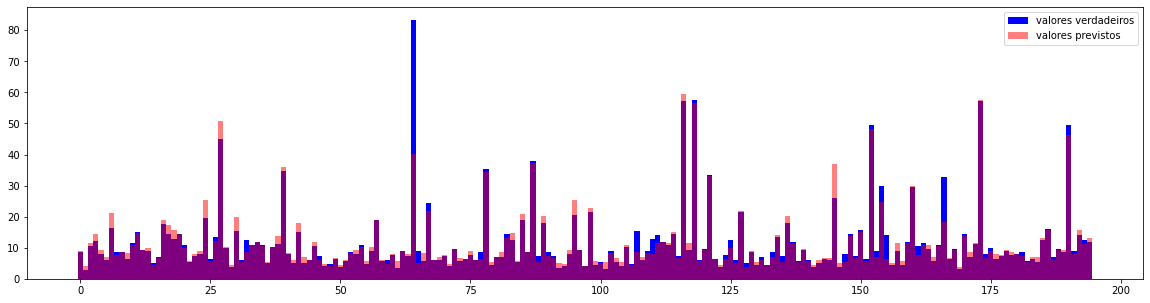

In [154]:
# Exibe 2 gráficos de barra: um com a amostragem dos dados de teste e o outro com os valores previstos pelo modelo
fig = plt.figure(figsize=(20,5))
plt.bar(list(range(len(y_test[::print_every]))), y_test.values[::print_every],
        alpha = 1, color = 'blue', width = 1, label = 'valores verdadeiros')
plt.bar(list(range(len(y_pred[::print_every]))), y_pred[::print_every],
        alpha = 0.5, color = 'red', width = 1, label = 'valores previstos')
plt.legend();

**Nos casos onde a barra vermelha é maior (menor) que a barra azul, significa que o valor previsto é maior (menor) que o valor verdadeiro.**

## 11 - Formato de resposta para o desafio do Kaggle

### Instruções

> **Submission File** <br>
> For each 'key' in the test set, you must predict a value for the `fare_amount` variable. The file should contain a header and have the following format:
>
>### Tradução
>**Arquivo para submissão**<br>
> Para cada chave ['key'] no conjunto de teste, você deverá prever um valor para a variável `fare_amount`. O arquivo deve conter um cabeçalho e apresentar o seguinte formato:
> 
> ```
> key,fare_amount
> 2015-01-27 13:08:24.0000002,11.00 ```



### 11.1 - Tratamento da base de dados de teste (test.csv)

**O tratamento executado, a seguir, na base de dados de teste (test.csv) deve ser capaz de deixar os dados no mesmo formato que os dados usados para treinamento e teste do modelo (train.csv). Após esse tratamento dos dados de teste, esses serão usados na previsão dos valores para a variável *fare_amount* que não se encontra nesse base de dados. Essa variável, então, é armazenada em um dataframe, juntamente com seus valores previstos, e, por sua vez, o dataframe poderia ser submetido a competição da plataforma Kaggle.**

In [175]:
# Carrega a base de dados de treinamento original, baixada do Kaggle
test = pd.read_csv('test.csv',
                    parse_dates = ['pickup_datetime'],
                    dtype = {'fare_amount': np.float32,
                             'pickup_latitude': np.float32,
                             'pickup_longitude': np.float32,
                             'dropoff_latitude': np.float32,
                             'dropoff_longitude': np.float32,
                             'passenger_count': np.int32,
                             'key': str             
                    })

In [176]:
# Exibe qntd de linhas e colunas
test.shape

(9914, 7)

In [177]:
# Exibe as 5 primeiras linhas de dados
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1


In [178]:
# Armazena a coluna key
key = test['key']

In [179]:
# Corverte o formato da data
pdt = test['pickup_datetime']
pdt = pdt.map(lambda date: date.tz_localize(None))
test.drop(['key'], axis = 1, inplace=True)
test['pickup_datetime'] = pdt

In [180]:
# Exibe as 5 primeiras linhas de dados com as datas convertidas
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12,-73.966049,40.789776,-73.988564,40.744427,1


In [181]:
# Cria os mesmos atributos da base de dados de treinamento, incluindo as distâncias euclidianas e Manhattan
test['hour_of_day'] = test['pickup_datetime'].map(lambda date: date.timetuple().tm_hour)
test['day_of_week'] = test['pickup_datetime'].map(lambda date: date.timetuple().tm_wday)
test['day_of_year'] = test['pickup_datetime'].map(lambda date: date.timetuple().tm_yday)
test['year'] = test['pickup_datetime'].map(lambda date: date.timetuple().tm_year)
test.drop('pickup_datetime', axis = 1, inplace = True)

# Distância
lon1, lon2 = np.radians(test['pickup_longitude']), np.radians(test['dropoff_longitude'])
lat1, lat2 = np.radians(test['pickup_latitude']), np.radians(test['dropoff_latitude'])
dlon = lon2 - lon1
dlat = lat2 - lat1

a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
test['eucl_distance'] = 6373 * c

a1 = np.sin(dlon/2)**2
c1 = 2 * np.arctan2(np.sqrt(a1), np.sqrt(1-a1))
a2 = np.sin(dlat/2)**2
c2 = 2 * np.arctan2(np.sqrt(a2), np.sqrt(1-a2))
test['manh_distance'] = 6373 * (c1+c2)

In [182]:
# Exibe as 5 primeiras linhas dos dados
test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,day_of_week,day_of_year,year,eucl_distance,manh_distance
0,-73.973320,40.763805,-73.981430,40.743835,1,13,1,27,2015,2.324087,3.123212
1,-73.986862,40.719383,-73.998886,40.739201,1,13,1,27,2015,2.426061,3.541439
2,-73.982521,40.751259,-73.979652,40.746140,1,11,5,281,2011,0.618597,0.888493
3,-73.981163,40.767807,-73.990448,40.751637,1,21,5,336,2012,1.961528,2.831859
4,-73.966049,40.789776,-73.988564,40.744427,1,21,5,336,2012,5.388903,7.548207


In [183]:
# Faz a normalização dos dados (escala entre 0 e 1)
X_test = test
X_test_scaled = standard_completa.transform(X_test)

In [184]:
# Armazena os valores previstos pelo modelo
y_pred = model.predict(X_test_scaled)

In [185]:
# Exibe alguns valores previstos
y_pred

array([10.233652 , 11.427668 ,  4.0272284, ..., 53.56088  , 17.889166 ,
        7.6557302], dtype=float32)

In [186]:
# Dataframe com a coluna key (chave) e os valores previstos
submission = pd.DataFrame({'key': key, 'fare_amount': y_pred})

In [187]:
# Exibe as 5 primeiras linhas de submission
submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.233652
1,2015-01-27 13:08:24.0000003,11.427668
2,2011-10-08 11:53:44.0000002,4.027228
3,2012-12-01 21:12:12.0000002,9.102667
4,2012-12-01 21:12:12.0000003,16.026714


In [188]:
# Salva o dataframe criado no formato .csv para enviá-lo para a competição do Kaggle
submission.to_csv('submission.csv', index = False)